# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
# *Timeseries Analysis*

Mark Bauer

# Goal
In this notebook, we perform basic timeseries analysis with NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to inspect the following questions:

- How have street flooding complaints changed over time city-wide and by borough?
- Is there any seasonality?
- Are there any overall trends?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   * [1. Importing Libraries](#1-Importing-Libraries)
       
       
   * [2. Loading Data](#2-Loading-Data)
       
       
   * [3. Data Inspection](#3-Data-Inspection)
       * [3.1 Basic Data Inspection](#31-Basic-Data-Inspection)
       * [3.2 Calculating Summary Statistics](#32-Calculating-Summary-Statistics)
       * [3.3 Identifying Null/NA Values](#33-Identifying-Null/NA-Values)
   
   
   * [4. Data Wrangling](#4-Data-Wrangling)
       * [4.1 Converting date column to Python's datetime64[ns] data type](#41-Converting-date-column-to-Pythons-datetime64[ns]-data-type)
       * [4.2 Dropping null values in our x, y coordinate columns](#42-Dropping-null-values-in-our-x-y-coordinate-columns)
       * [4.3 Creating a GeoDataframe from x,y coordinates](#43-Creating-a-GeoDataframe-from-x-y-coordinates)
       

   * [5. Mapping](#5-Mapping)
       * [5.1 Citywide](#51-Citywide)
       * [5.2 By Borough](#52-By-Borough)
       * [5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)](#53-Bar-Charts-by-Neighborhood-Tabulation-Areas-(NTA))

      
   * [6. Time Series Analysis](#6-Time-Series-Analysis)
       * [6.1 By Year and Borough](#61-By-Year-and-Borough)
       * [6.2 Frequencies](#62-Frequencies)
       * [6.3 Resampling](#63-Resampling)
       * [6.4 Seasonality](#64-Seasonality)
       * [6.5 Resampling for Frequency Average](#65-Resampling-for-Frequency-Average)
       * [6.6 Rolling Averages](66-Rolling-Averages)
       * [6.7 Additional Time Series Analysis](#67-Additional-Time-Series-Analysis)
   
          
   * [7. Anomoly Detection](#7-Anomoly-Detection)
   
          
   * [8. Manually Formatting Date Tick Labels](#8-Manually-Formatting-Date-Tick-Labels)
   
   
   * [9. Timedelta of Complaints](#9-Timedelta-of-Complaints)
   
          
   * [10. Conclusion](#10-Conclusion)

# 1. Importing Libraries

In [929]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [930]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [931]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
geoplot 0.4.0
fiona 1.8.13.post1
matplotlib.pyplot 3.3.2
seaborn 0.11.1


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [932]:
# list items in data folder
%ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [933]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw_street_flooding_complaints.csv', \
                           low_memory = False)

# previewing first five rows in data
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,due_date,location_type,landmark
0,19224496,2010-11-29T20:01:00.000,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,NaN,NaN,NaN
1,38610039,2018-03-04T06:10:00.000,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,NaN,NaN,NaN
2,19379336,2010-12-18T11:01:00.000,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,NaN,NaN,NaN
3,19406934,2010-12-22T08:39:00.000,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,NaN,NaN,NaN
4,19424458,2010-12-26T10:44:00.000,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,NaN,NaN,NaN


In [934]:
# previewing the last five rows of our dataframe
flooding_311.tail()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,due_date,location_type,landmark
27423,36899327,2017-08-08T14:46:00.000,2017-09-10T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,COLFAX ST,212 ST,...,NaN,NaN,NaN,NaN,COLFAX ST,212 ST,NaN,NaN,NaN,NaN
27424,36903138,2017-08-09T10:09:00.000,2017-08-09T11:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,NaN,...,NaN,NaN,FLATLANDS AVE,FLATLANDS AVE,VAN SICLEN AVE,SCHENK AVE,NaN,NaN,NaN,NaN
27425,36974378,2017-08-18T11:25:00.000,2017-08-18T14:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,NaN,...,NaN,NaN,LINDEN PL,LINDEN PL,28 AVE,WHITESTONE EXPY,NaN,NaN,NaN,NaN
27426,36979728,2017-08-18T16:26:00.000,2017-08-18T18:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,NaN,...,NaN,NaN,1 AVE,1 AVE,E 16 ST,E 18 ST,NaN,NaN,NaN,NaN
27427,36984240,2017-08-19T15:39:00.000,2017-08-20T08:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,BEACH 84 ST,ROCKAWAY FRWY,...,NaN,NaN,NaN,NaN,BEACH 84 ST,ROCKAWAY FRWY,NaN,NaN,NaN,NaN


In [935]:
print(flooding_311.shape)

(27428, 34)


In [936]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [937]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [938]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
intersection_street_1              object
intersection_street_2              object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
latitude                          

In [939]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  facility_type                   

In [940]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [941]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [942]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  status                          

In [943]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [944]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [945]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27428
Name: descriptor, dtype: int64

In [946]:
flooding_311['agency'].value_counts()

DEP    27428
Name: agency, dtype: int64

In [947]:
flooding_311['agency_name'].value_counts()

Department of Environmental Protection    27428
Name: agency_name, dtype: int64

In [948]:
flooding_311['complaint_type'].value_counts()

Sewer    27428
Name: complaint_type, dtype: int64

In [949]:
flooding_311['status'].value_counts()

Closed      27421
Pending         4
Started         2
Assigned        1
Name: status, dtype: int64

In [950]:
flooding_311.created_date.min()

'2010-01-02T08:26:00.000'

In [951]:
flooding_311.created_date.max()

'2020-12-31T15:41:00.000'

In [952]:
print('This dataset is from', \
      flooding_311.created_date.min()[0:10], \
      'to', \
      flooding_311.created_date.max()[0:10] + \
      '.')

This dataset is from 2010-01-02 to 2020-12-31.


## 3.2 Calcualting Summary Statistics

In [953]:
# display floats up to three decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [954]:
# printing descriptive statistics of our numeric columns in our data
flooding_311.describe()

,unique_key,incident_zip,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,bbl
count,27428.00,26575.00,26491.00,26491.00,26491.00,26491.00,15816.00
mean,32240462.88,10969.86,1005575.87,186159.58,40.68,-73.92,3700761123.31
std,9145119.01,536.76,35049.08,30573.55,0.08,0.13,1075451518.51
min,15639934.00,10001.00,913357.00,121032.00,40.50,-74.25,0.00
25%,24209554.00,10312.00,986927.00,161238.00,40.61,-73.99,3060562512.50
50%,32631370.50,11221.00,1007562.00,183608.00,40.67,-73.92,4069055005.00
75%,40019588.25,11385.00,1034057.50,206502.00,40.73,-73.82,4156502522.75
max,48543132.00,11697.00,1067279.00,271876.00,40.91,-73.70,5080500078.00


In [955]:
flooding_311.describe(include=['O']).T

,count,unique,top,freq
created_date,27428,25975,2011-08-28T00:00:00.000,13
closed_date,27426,25022,2017-05-06T08:30:00.000,36
agency,27428,1,DEP,27428
agency_name,27428,1,Department of Environmental Protection,27428
complaint_type,27428,1,Sewer,27428
descriptor,27428,1,Street Flooding (SJ),27428
intersection_street_1,9981,2810,BROADWAY,97
intersection_street_2,9981,2826,BROADWAY,168
address_type,27422,3,ADDRESS,16380
city,26576,87,BROOKLYN,6831


## 3.3 Identifying Null/NA Values

In [956]:
print('Sum of nulls in each column:')
flooding_311.isna().sum().sort_values(ascending=False)

Sum of nulls in each column:


intersection_street_2             17447
intersection_street_1             17447
bbl                               11612
street_name                        9924
incident_address                   9924
cross_street_2                     3718
cross_street_1                     3706
location                            937
longitude                           937
latitude                            937
x_coordinate_state_plane            937
y_coordinate_state_plane            937
incident_zip                        853
city                                852
resolution_description                7
address_type                          6
closed_date                           2
park_facility_name                    0
park_borough                          0
unique_key                            0
open_data_channel_type                0
borough                               0
created_date                          0
resolution_action_updated_date        0
status                                0


In [957]:
print('Sum of nulls in all columns: {}'.format(f'{flooding_311.isna().sum().sum():,}'))

Sum of nulls in all columns: 80,183


In [958]:
print('Identifying nulls in column (True/False):')
flooding_311.isna().head()

Identifying nulls in column (True/False):


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_facility_name,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl
0,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True,False,False,...,False,False,True,True,True,True,True,False,False,True
2,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True


In [959]:
print('Identifying any null values in each column (True/False):')
flooding_311.isna().any().sort_values(ascending=False)

Identifying any null values in each column (True/False):


bbl                                True
address_type                       True
x_coordinate_state_plane           True
latitude                           True
longitude                          True
resolution_description             True
location                           True
city                               True
intersection_street_2              True
intersection_street_1              True
incident_zip                       True
incident_address                   True
street_name                        True
cross_street_1                     True
cross_street_2                     True
closed_date                        True
y_coordinate_state_plane           True
park_facility_name                False
park_borough                      False
unique_key                        False
open_data_channel_type            False
borough                           False
created_date                      False
resolution_action_updated_date    False
status                            False


In [960]:
# return a boolean same-sized object indicating if any of the values are NA
flooding_311.isna().any().value_counts()

True     17
False    13
dtype: int64

In [961]:
# return descriptive statistics of boolean indicating if any of the values are NA
flooding_311.isna().any().describe()

count       30
unique       2
top       True
freq        17
dtype: object

In [962]:
# calculating a percentage of the number of nulls to total number of records of each column
missing_data = (flooding_311.isna().sum() / len(flooding_311)) * 100

# creating a dataframe
missing_data = pd.DataFrame({'Missing Ratio (%)' :missing_data}) 
missing_data.sort_values(by='Missing Ratio (%)', 
                         ascending=False, 
                         inplace=True)

missing_data.head(len(missing_data))

,Missing Ratio (%)
intersection_street_2,63.61
intersection_street_1,63.61
bbl,42.34
street_name,36.18
incident_address,36.18
cross_street_2,13.56
cross_street_1,13.51
location,3.42
longitude,3.42
latitude,3.42


In [963]:
len(flooding_311.columns)

30

In [964]:
flooding_311.iloc[:,:15].head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,address_type,city,status,resolution_description,resolution_action_updated_date
0,19224496,2010-11-29T20:01:00.000,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,BLOCKFACE,BROOKLYN,Closed,The Department of Environment Protection inspe...,2010-11-30T08:50:00.000
1,38610039,2018-03-04T06:10:00.000,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,INTERSECTION,NaN,Closed,The Department of Environment Protection inspe...,2018-03-07T10:00:00.000
2,19379336,2010-12-18T11:01:00.000,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,ADDRESS,STATEN ISLAND,Closed,The Department of Environmental Protection has...,2011-01-10T15:00:00.000
3,19406934,2010-12-22T08:39:00.000,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,ADDRESS,OZONE PARK,Closed,The Department of Environment Protection inspe...,2011-01-03T09:55:00.000
4,19424458,2010-12-26T10:44:00.000,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,INTERSECTION,WHITESTONE,Closed,The Department of Environment Protection inspe...,2010-12-26T11:55:00.000


In [965]:
flooding_311.iloc[:,15:].head()

,community_board,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl
0,14 BROOKLYN,BROOKLYN,997001.00,163787.00,UNKNOWN,Unspecified,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN
1,Unspecified BROOKLYN,BROOKLYN,NaN,NaN,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN
2,02 STATEN ISLAND,STATEN ISLAND,956757.00,158713.00,UNKNOWN,Unspecified,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00
3,09 QUEENS,QUEENS,1028044.00,190125.00,UNKNOWN,Unspecified,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00
4,Unspecified QUEENS,QUEENS,1035553.00,229598.00,UNKNOWN,Unspecified,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN


# 4. Data Wrangling

## 4.1 Converting date column to Python's datetime64[ns] data type

In [966]:
flooding_311.created_date = pd.to_datetime(flooding_311.created_date)
flooding_311['year'] = flooding_311['created_date'].dt.year

print('Formatting our create_date column as', flooding_311.created_date.dtype, \
      'and extracting a year column.')

Formatting our create_date column as datetime64[ns] and extracting a year column.


In [967]:
flooding_311[['created_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  27428 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 214.4 KB


In [968]:
print('Summary statistics on our date column.')

flooding_311[['created_date']].describe(datetime_is_numeric=True)

Summary statistics on our date column.


,created_date
count,27428
mean,2015-09-29 22:49:07.109522944
min,2010-01-02 08:26:00
25%,2012-10-16 09:19:45
50%,2016-02-08 19:47:30
75%,2018-08-15 15:17:00
max,2020-12-31 15:41:00


In [969]:
print('Summary statistics on our year column.')

flooding_311[['year']].describe()

Summary statistics on our year column.


,year
count,27428.00
mean,2015.24
std,3.22
min,2010.00
25%,2012.00
50%,2016.00
75%,2018.00
max,2020.00


In [970]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010


In [971]:
len(flooding_311)

27428

<AxesSubplot:>

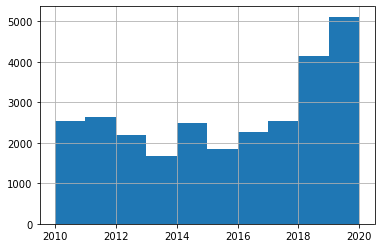

In [972]:
flooding_311['year'].hist()

<AxesSubplot:ylabel='Density'>

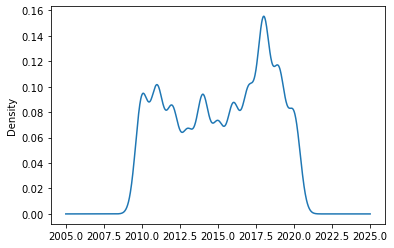

In [973]:
flooding_311['year'].plot.kde()

<AxesSubplot:>

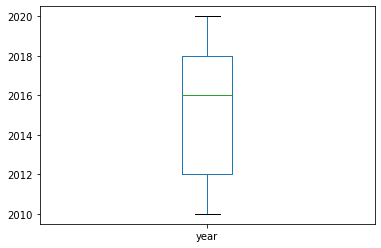

In [974]:
flooding_311['year'].plot.box()

# 6. Time Series Analysis

In [975]:
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      27428 non-null  int64         
 1   created_date                    27428 non-null  datetime64[ns]
 2   closed_date                     27426 non-null  object        
 3   agency                          27428 non-null  object        
 4   agency_name                     27428 non-null  object        
 5   complaint_type                  27428 non-null  object        
 6   descriptor                      27428 non-null  object        
 7   incident_zip                    26575 non-null  float64       
 8   intersection_street_1           9981 non-null   object        
 9   intersection_street_2           9981 non-null   object        
 10  address_type                    27422 non-null  object        
 11  ci

In [976]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010


## 6.1 By Year and Borough

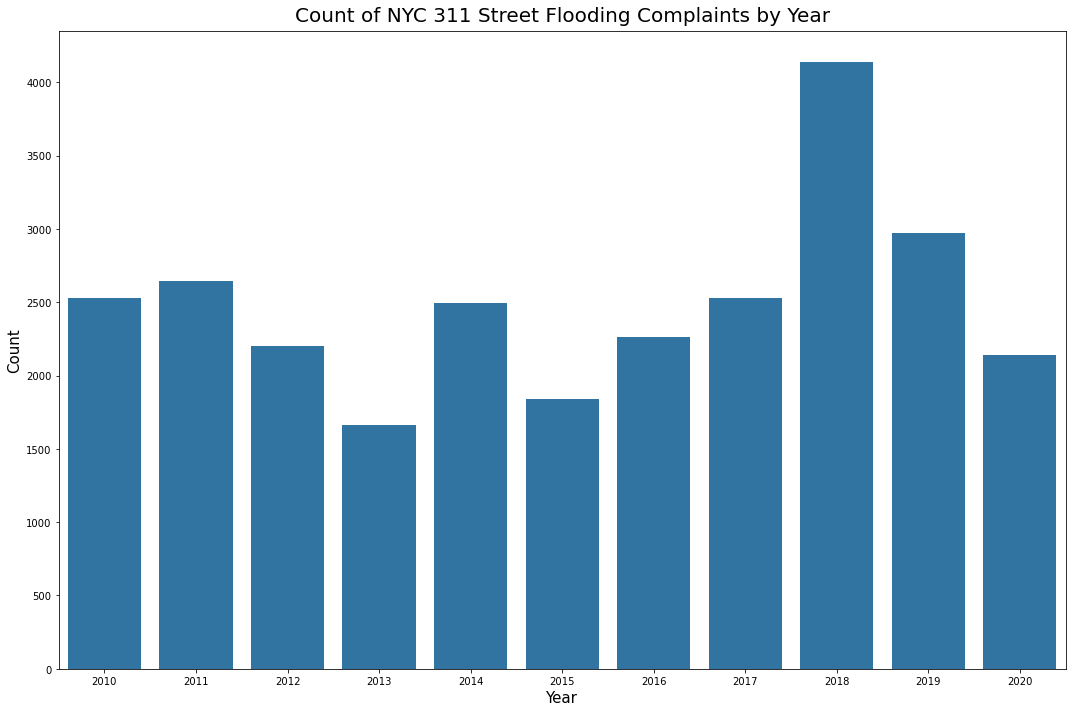

In [977]:
plt.figure(figsize=(15,10))

sns.countplot(x=flooding_311['year'],
              color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by Year', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()
plt.savefig('figures/pres-6.png')

In [978]:
flooding_311.borough.value_counts()

QUEENS           10900
BROOKLYN          6970
STATEN ISLAND     4925
MANHATTAN         2583
BRONX             2039
Unspecified         11
Name: borough, dtype: int64

In [979]:
flooding_311.loc[flooding_311.borough != 'Unspecified'].borough.value_counts()

QUEENS           10900
BROOKLYN          6970
STATEN ISLAND     4925
MANHATTAN         2583
BRONX             2039
Name: borough, dtype: int64

In [980]:
flooding_311 = flooding_311.loc[flooding_311.borough != 'Unspecified']

flooding_311.borough.value_counts()

QUEENS           10900
BROOKLYN          6970
STATEN ISLAND     4925
MANHATTAN         2583
BRONX             2039
Name: borough, dtype: int64

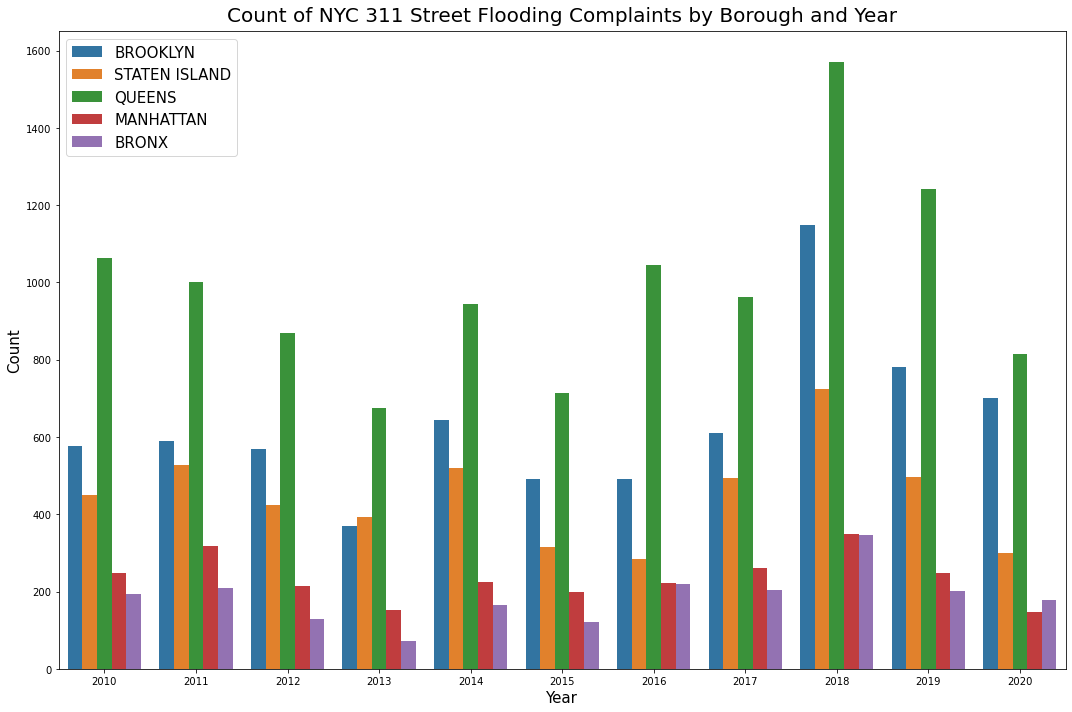

In [981]:
plt.figure(figsize=(15,10))

sns.countplot(x="year", 
              data=flooding_311,
              hue='borough')


plt.title('Count of NYC 311 Street Flooding Complaints by Borough and Year', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

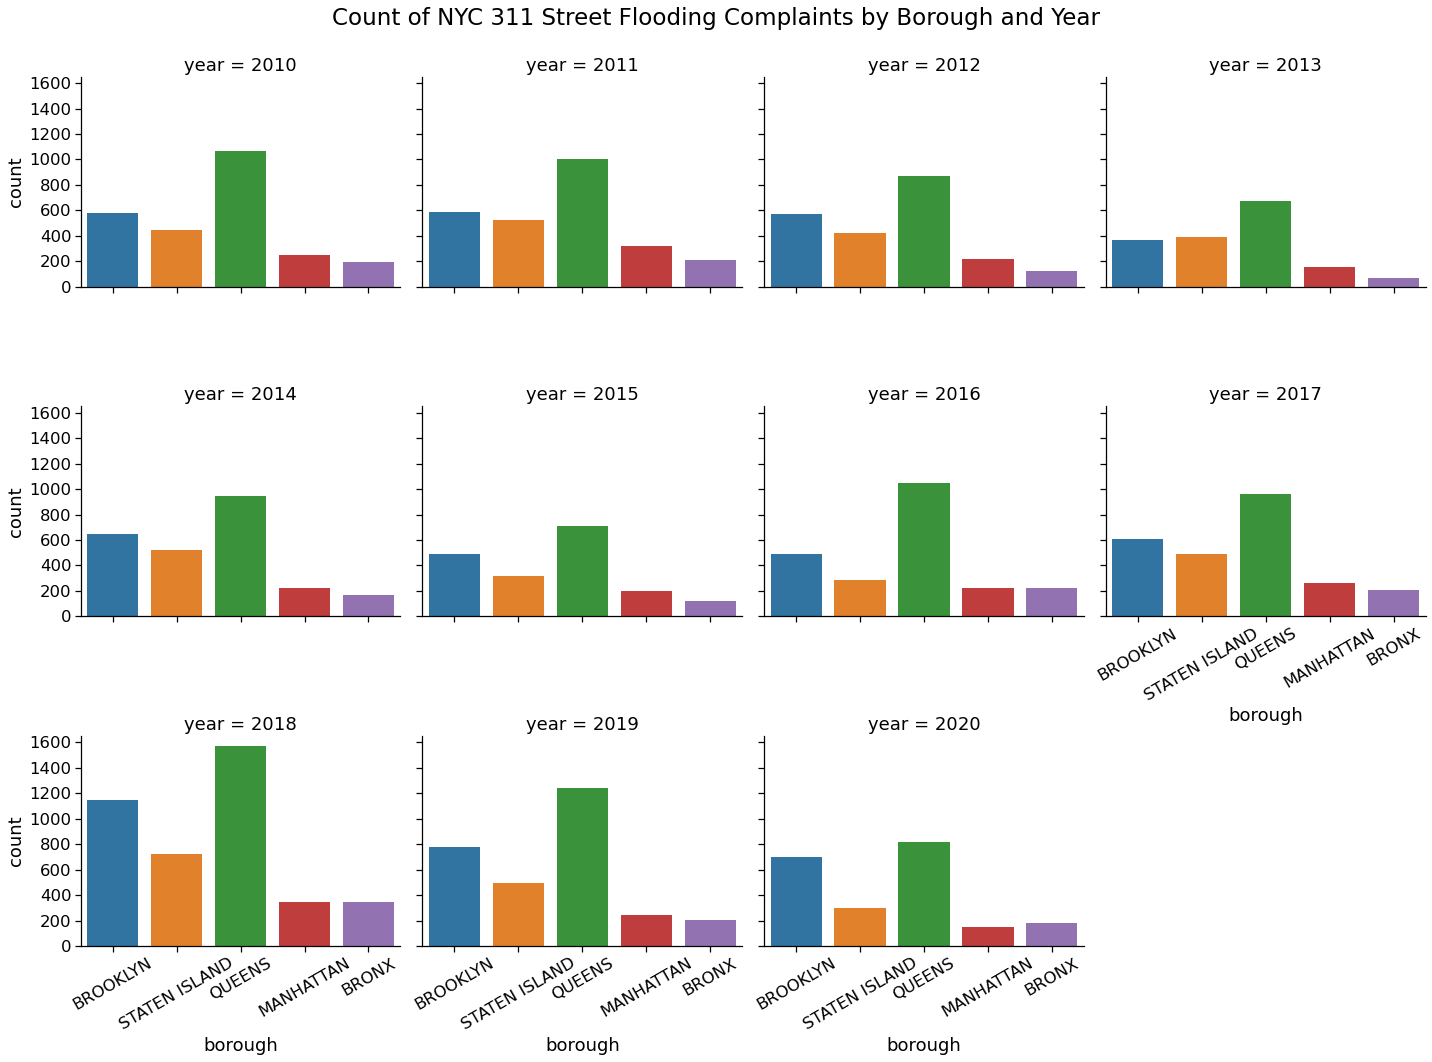

In [982]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.catplot(x="borough",
                col="year",
                data=flooding_311,
                kind='count',
                col_wrap=4)

    g.set_xticklabels(rotation=30)


plt.suptitle('Count of NYC 311 Street Flooding Complaints by Borough and Year\n', 
          fontsize=23)
plt.subplots_adjust(top=0.9)
plt.tight_layout()

In [983]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010


# Saving data

In [984]:
print(flooding_311.shape)
flooding_311.to_csv('data-output/flooding_311.csv', index=False)

(27417, 31)


In [985]:
pd.read_csv('data-output/flooding_311.csv').shape

(27417, 31)

In [986]:
pd.read_csv('data-output/flooding_311.csv').head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010


In [987]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,park_borough,latitude,longitude,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,BROOKLYN,40.62,-73.95,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,STATEN ISLAND,40.60,-74.10,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,QUEENS,40.69,-73.84,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,QUEENS,40.80,-73.81,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010


In [988]:
stacked_bar = pd.pivot_table(flooding_311, 
                             values='unique_key', 
                             index=['year'], 
                             columns = ['borough'], 
                             aggfunc=pd.Series.nunique)

stacked_bar.rename({'unique_key': 'count'}, 
                   axis=1, 
                   inplace=True)

In [989]:
stacked_bar.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,193,576,248,1064,450
2011,208,589,317,1000,527
2012,128,568,215,869,423
2013,72,370,152,676,394
2014,166,644,225,944,519


In [990]:
stacked_bar.index

Int64Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year')

In [991]:
stacked_bar.index = stacked_bar.index.astype('int64')
stacked_bar.index.dtype

dtype('int64')

In [992]:
for item in stacked_bar.index:
    print(item)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


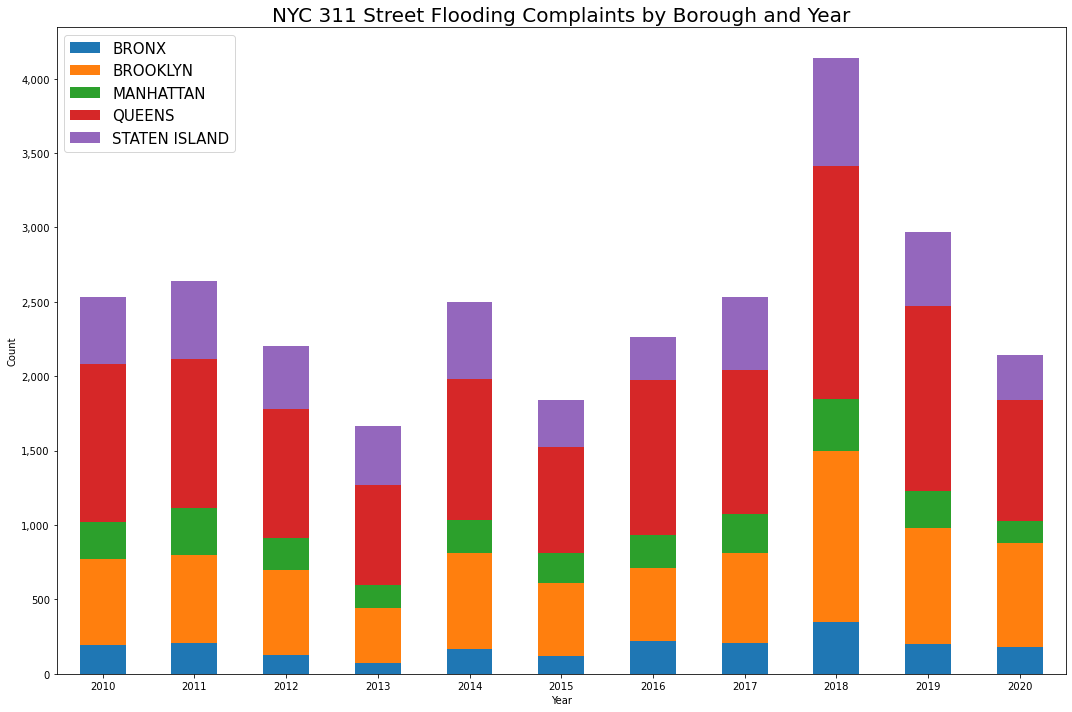

In [993]:
fig, ax = plt.subplots(figsize=(15,10))

stacked_bar.plot.bar(stacked=True, ax=ax)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

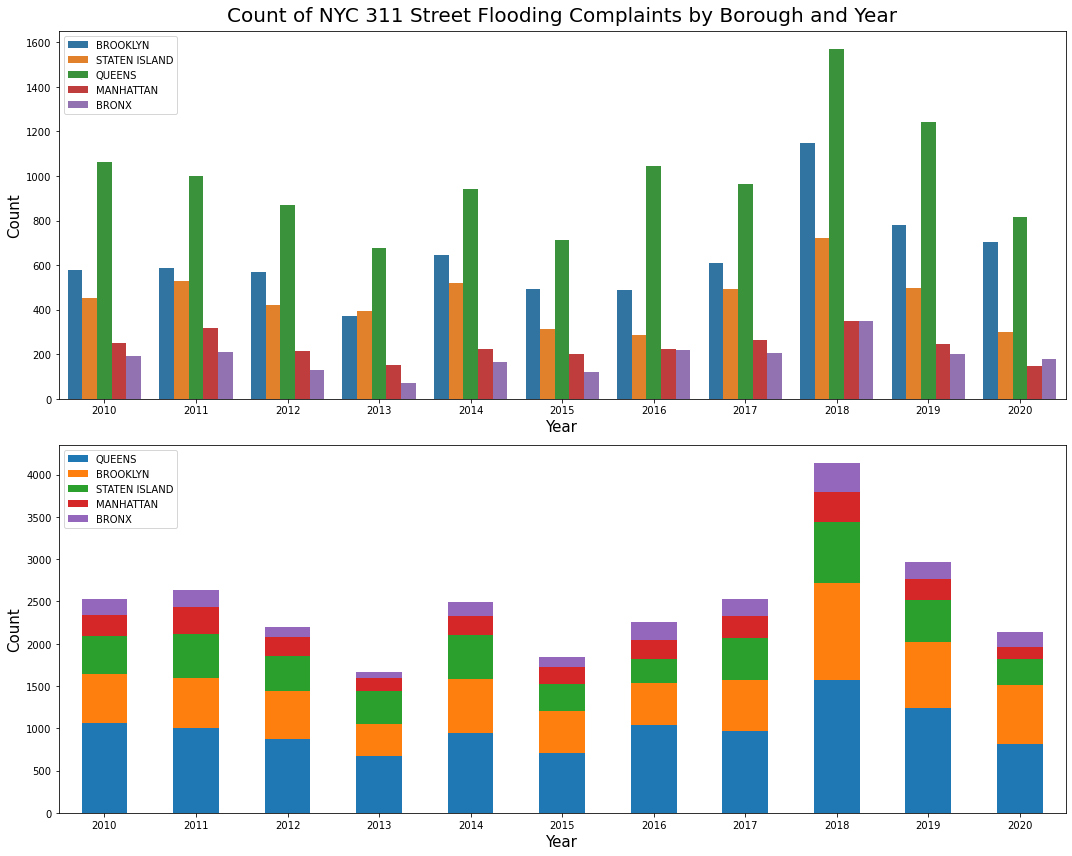

In [994]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 12))

sns.countplot(x="year", 
              data=flooding_311,
              hue='borough',
              ax=axs[0])


axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Borough and Year', 
          fontsize=20,
          pad=10)
axs[0].set_ylabel('Count', fontsize=15)
axs[0].set_xlabel('Year', fontsize=15)
axs[0].legend(loc=2, fontsize=10)


stacked_bar = stacked_bar[['QUEENS', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN', 'BRONX']]
stacked_bar.plot.bar(stacked=True, 
                     ax=axs[1])

# axs[1].set_title('CountNYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.xticks(rotation=0)
axs[1].set_ylabel('Count', fontsize=15)
axs[1].set_xlabel('Year', fontsize=15)
axs[1].legend(loc=2, fontsize=10)

plt.tight_layout()
plt.savefig('figures/pres-7.png')

In [995]:
stacked_bar.head()

borough,QUEENS,BROOKLYN,STATEN ISLAND,MANHATTAN,BRONX
year,,,,,
2010,1064,576,450,248,193
2011,1000,589,527,317,208
2012,869,568,423,215,128
2013,676,370,394,152,72
2014,944,644,519,225,166


In [996]:
stacked_bar.reset_index()

borough,year,QUEENS,BROOKLYN,STATEN ISLAND,MANHATTAN,BRONX
0,2010,1064,576,450,248,193
1,2011,1000,589,527,317,208
2,2012,869,568,423,215,128
3,2013,676,370,394,152,72
4,2014,944,644,519,225,166
5,2015,713,492,315,199,120
6,2016,1044,490,285,223,220
7,2017,963,610,493,262,204
8,2018,1571,1149,723,348,347
9,2019,1242,780,496,247,202


# Saving Data

In [997]:
print(stacked_bar.shape)
stacked_bar.reset_index().to_csv('data-output/stacked_bar.csv', index=False)

(11, 5)


In [998]:
pd.read_csv('data-output/stacked_bar.csv').shape

(11, 6)

In [999]:
pd.read_csv('data-output/stacked_bar.csv').head()

,year,QUEENS,BROOKLYN,STATEN ISLAND,MANHATTAN,BRONX
0,2010,1064,576,450,248,193
1,2011,1000,589,527,317,208
2,2012,869,568,423,215,128
3,2013,676,370,394,152,72
4,2014,944,644,519,225,166


In [1000]:
pivot_table = pd.pivot_table(flooding_311, 
                             values='unique_key', 
                             index=['year'], 
                             columns = ['borough'], 
                             aggfunc=pd.Series.nunique)

pivot_table.rename({'unique_key': 'count'}, axis=1, inplace=True)
pivot_table.index = pivot_table.index.astype('int64')

print(pivot_table.index.dtype)

int64


In [1001]:
pivot_table.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,193,576,248,1064,450
2011,208,589,317,1000,527
2012,128,568,215,869,423
2013,72,370,152,676,394
2014,166,644,225,944,519


In [1002]:
pivot_table.columns

Index(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'], dtype='object', name='borough')

In [1003]:
pivot_table = pivot_table[['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']]

pivot_table.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,193,576,248,1064,450
2011,208,589,317,1000,527
2012,128,568,215,869,423
2013,72,370,152,676,394
2014,166,644,225,944,519


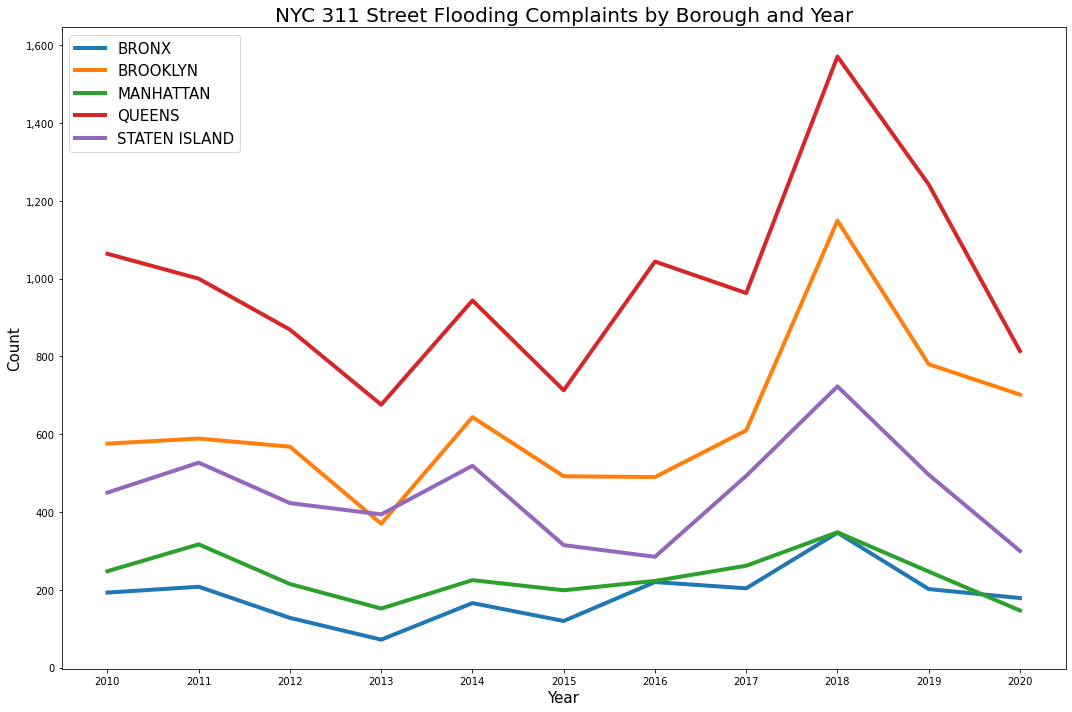

In [1004]:
fig, ax = plt.subplots(figsize=(15,10))

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_table.plot.line(ax=ax, linewidth=4)

plt.xticks(rotation=0)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('NYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

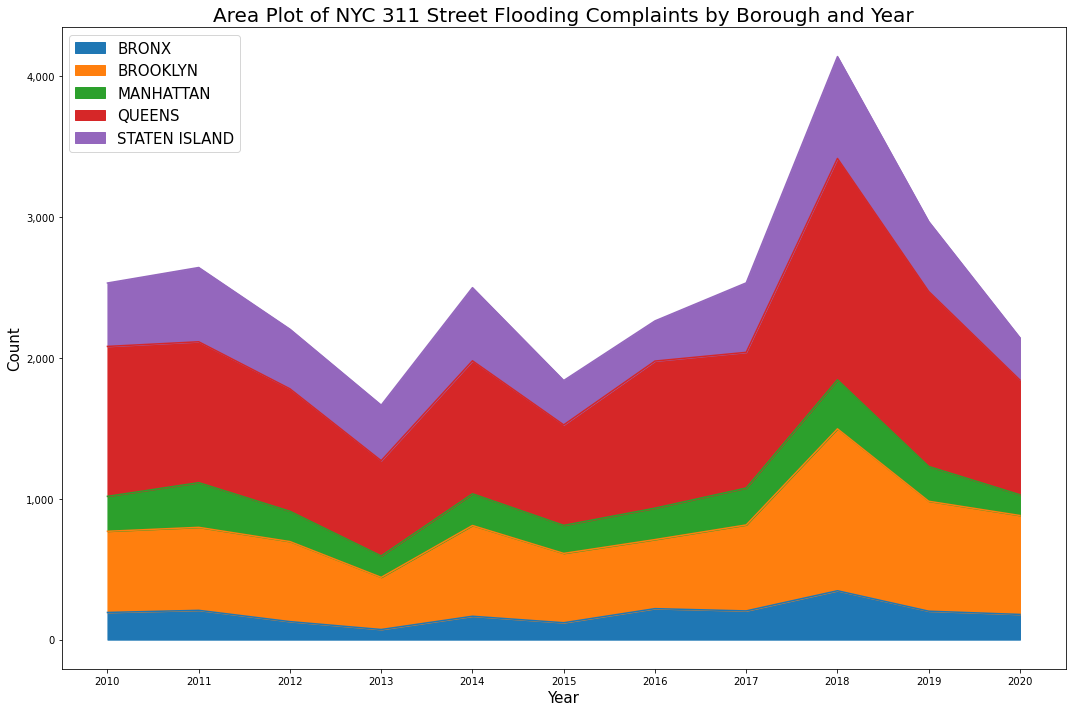

In [1005]:
fig, ax = plt.subplots(figsize=(15,10))

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_table.plot.area(ax=ax)

plt.ylabel('Count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Area Plot of NYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

In [1006]:
pivot_table_cumsum = pivot_table.cumsum()
pivot_table_cumsum.head()

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,193,576,248,1064,450
2011,401,1165,565,2064,977
2012,529,1733,780,2933,1400
2013,601,2103,932,3609,1794
2014,767,2747,1157,4553,2313


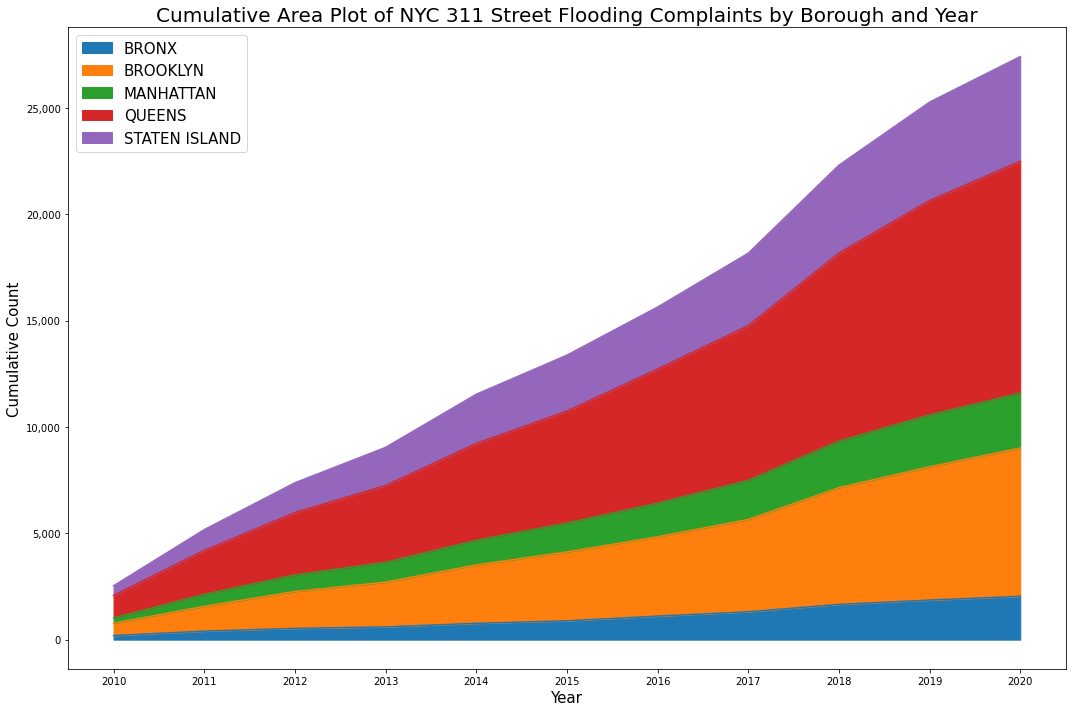

In [1007]:
fig, ax = plt.subplots(figsize=(15,10))

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

pivot_table_cumsum.plot.area(ax=ax)

plt.xticks(rotation=0)
plt.ylabel('Cumulative Count', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Cumulative Area Plot of NYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

In [1008]:
data_perc = pivot_table.divide(pivot_table.sum(axis=0), axis=1)

data_perc.head(len(data_perc))

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
year,,,,,
2010,0.09,0.08,0.10,0.10,0.09
2011,0.10,0.08,0.12,0.09,0.11
2012,0.06,0.08,0.08,0.08,0.09
2013,0.04,0.05,0.06,0.06,0.08
2014,0.08,0.09,0.09,0.09,0.11
2015,0.06,0.07,0.08,0.07,0.06
2016,0.11,0.07,0.09,0.10,0.06
2017,0.10,0.09,0.10,0.09,0.10
2018,0.17,0.16,0.13,0.14,0.15


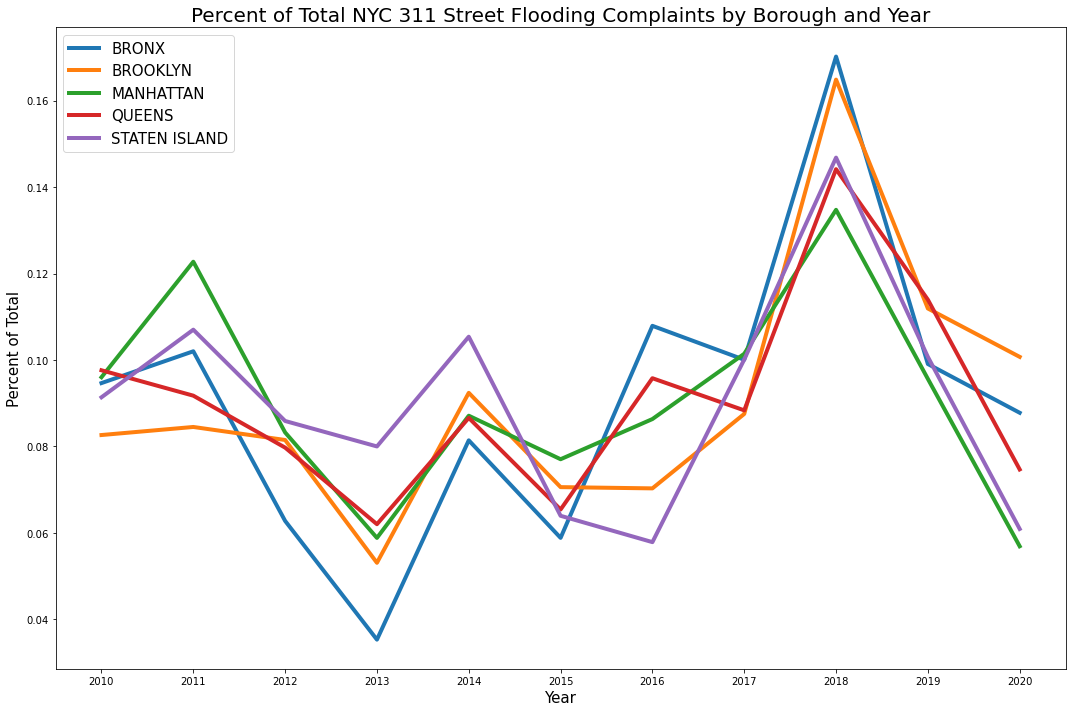

In [1009]:
fig, ax = plt.subplots(figsize=(15,10))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))

data_perc.plot(ax=ax, 
               linewidth=4)

plt.xticks(rotation=0)
plt.ylabel('Percent of Total', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.title('Percent of Total NYC 311 Street Flooding Complaints by Borough and Year', fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.tight_layout()

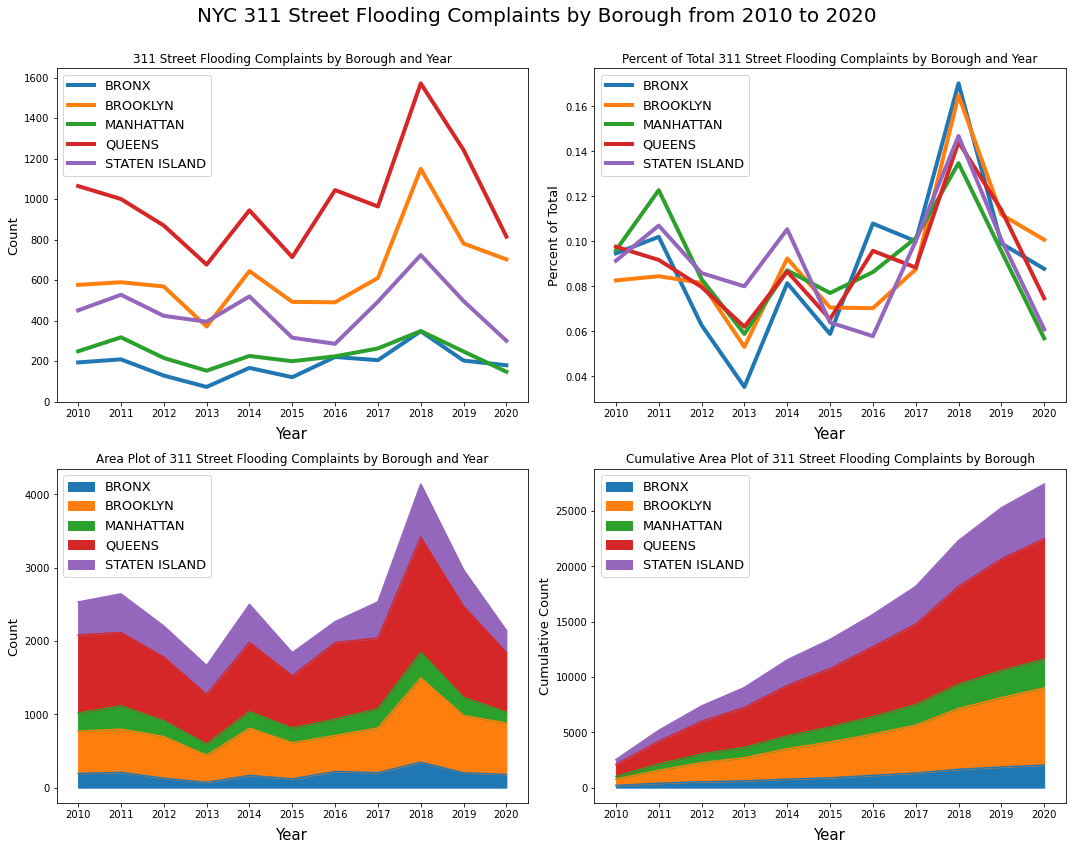

In [1010]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))


pivot_table.plot.line(linewidth=4, ax=axs[0,0])
axs[0,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,0].set_ylabel('Count', fontsize=13)
axs[0,0].set_title('311 Street Flooding Complaints by Borough and Year', fontsize=12)

data_perc.plot(ax=axs[0,1], linewidth=4)
axs[0,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[0,1].tick_params(labelrotation=0)
axs[0,1].legend(loc=2, title='borough')
axs[0,1].set_ylabel('Percent of Total', fontsize=13)
axs[0,1].set_title('Percent of Total 311 Street Flooding Complaints by Borough and Year', fontsize=12)

pivot_table.plot.area(ax=axs[1,0])
axs[1,0].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,0].set_ylabel('Count', fontsize=13)
axs[1,0].set_title('Area Plot of 311 Street Flooding Complaints by Borough and Year', fontsize=12)
    
pivot_table_cumsum.plot.area(ax=axs[1,1])
axs[1,1].xaxis.set_major_locator(plt.MultipleLocator(1))
axs[1,1].set_ylabel('Cumulative Count', fontsize=13)
axs[1,1].set_title('Cumulative Area Plot of 311 Street Flooding Complaints by Borough', fontsize=12)


for ax in axs.flat:
    ax.set_xlabel('Year', fontsize=15, labelpad=8) 
    ax.legend(loc=2, fontsize=13)

fig.suptitle('NYC 311 Street Flooding Complaints by Borough from 2010 to 2020\n', fontsize=20) 

plt.tight_layout()
plt.savefig('figures/pres-6.png')

In [1011]:
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27417 entries, 0 to 27427
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      27417 non-null  int64         
 1   created_date                    27417 non-null  datetime64[ns]
 2   closed_date                     27415 non-null  object        
 3   agency                          27417 non-null  object        
 4   agency_name                     27417 non-null  object        
 5   complaint_type                  27417 non-null  object        
 6   descriptor                      27417 non-null  object        
 7   incident_zip                    26569 non-null  float64       
 8   intersection_street_1           9975 non-null   object        
 9   intersection_street_2           9975 non-null   object        
 10  address_type                    27414 non-null  object        
 11  ci

In [1012]:
flooding_311['year_month_day'] = flooding_311['created_date'].dt.strftime('%Y-%m-%d')
flooding_311['year_month'] = flooding_311['created_date'].dt.strftime('%Y-%m')
flooding_311['year_month_week'] = flooding_311['created_date'].dt.strftime('%Y-%W')

flooding_311.year_month_day = pd.to_datetime(flooding_311.year_month_day)
flooding_311['year_month'] = pd.to_datetime(flooding_311.year_month)
flooding_311['year_month_week'] = pd.to_datetime(flooding_311.year_month_week + '0', format='%Y-%W%w')

In [1013]:
create_date = [flooding_311.columns[1]]
print('Preview our original date column\n', create_date)

new_cols = list(flooding_311.iloc[:, -3:].columns)
print('Preview new columns\n', new_cols)

new_cols = create_date + new_cols 
print('Preview original and new columns\n', new_cols)

Preview our original date column
 ['created_date']
Preview new columns
 ['year_month_day', 'year_month', 'year_month_week']
Preview original and new columns
 ['created_date', 'year_month_day', 'year_month', 'year_month_week']


In [1014]:
flooding_311[new_cols].head(10)

,created_date,year_month_day,year_month,year_month_week
0,2010-11-29 20:01:00,2010-11-29,2010-11-01,2010-12-05
1,2018-03-04 06:10:00,2018-03-04,2018-03-01,2018-03-04
2,2010-12-18 11:01:00,2010-12-18,2010-12-01,2010-12-19
3,2010-12-22 08:39:00,2010-12-22,2010-12-01,2010-12-26
4,2010-12-26 10:44:00,2010-12-26,2010-12-01,2010-12-26
5,2010-12-30 12:31:00,2010-12-30,2010-12-01,2011-01-02
6,2010-12-30 13:21:00,2010-12-30,2010-12-01,2011-01-02
7,2011-01-02 10:13:00,2011-01-02,2011-01-01,2011-01-02
8,2011-01-02 18:10:00,2011-01-02,2011-01-01,2011-01-02
9,2011-01-03 07:43:00,2011-01-03,2011-01-01,2011-01-09


In [1015]:
flooding_311[new_cols].tail(10)

,created_date,year_month_day,year_month,year_month_week
27418,2019-05-31 13:19:00,2019-05-31,2019-05-01,2019-06-02
27419,2020-01-31 22:25:00,2020-01-31,2020-01-01,2020-02-02
27420,2017-07-23 09:19:00,2017-07-23,2017-07-01,2017-07-23
27421,2017-08-04 10:28:00,2017-08-04,2017-08-01,2017-08-06
27422,2017-08-04 11:19:00,2017-08-04,2017-08-01,2017-08-06
27423,2017-08-08 14:46:00,2017-08-08,2017-08-01,2017-08-13
27424,2017-08-09 10:09:00,2017-08-09,2017-08-01,2017-08-13
27425,2017-08-18 11:25:00,2017-08-18,2017-08-01,2017-08-20
27426,2017-08-18 16:26:00,2017-08-18,2017-08-01,2017-08-20
27427,2017-08-19 15:39:00,2017-08-19,2017-08-01,2017-08-20


In [1016]:
flooding_311.iloc[:, -3:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27417 entries, 0 to 27427
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year_month_day   27417 non-null  datetime64[ns]
 1   year_month       27417 non-null  datetime64[ns]
 2   year_month_week  27417 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 1.8 MB


In [1017]:
flooding_311.iloc[:, -3:].describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
year_month_day,27417,2015-09-29 03:52:21.481562368,2010-01-02,2012-10-16,2016-02-08,2018-08-15,2020-12-31
year_month,27417,2015-09-14 07:18:43.055038976,2010-01-01,2012-10-01,2016-02-01,2018-08-01,2020-12-01
year_month_week,27417,2015-10-02 15:24:26.549950720,2010-01-03,2012-10-21,2016-02-14,2018-08-19,2021-01-03


In [1018]:
flooding_311.iloc[:, -3:].isna().sum()

year_month_day     0
year_month         0
year_month_week    0
dtype: int64

In [1019]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year,year_month_day,year_month,year_month_week
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010,2010-11-29,2010-11-01,2010-12-05
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018,2018-03-04,2018-03-01,2018-03-04
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010,2010-12-18,2010-12-01,2010-12-19
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010,2010-12-22,2010-12-01,2010-12-26
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010,2010-12-26,2010-12-01,2010-12-26


In [1020]:
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27417 entries, 0 to 27427
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      27417 non-null  int64         
 1   created_date                    27417 non-null  datetime64[ns]
 2   closed_date                     27415 non-null  object        
 3   agency                          27417 non-null  object        
 4   agency_name                     27417 non-null  object        
 5   complaint_type                  27417 non-null  object        
 6   descriptor                      27417 non-null  object        
 7   incident_zip                    26569 non-null  float64       
 8   intersection_street_1           9975 non-null   object        
 9   intersection_street_2           9975 non-null   object        
 10  address_type                    27414 non-null  object        
 11  ci

## 6.2 Frequencies

In [1021]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()
flooding_311_daily.rename(index="count", inplace=True)

flooding_311_daily

year_month_day
2010-01-02     3
2010-01-04     1
2010-01-05     1
2010-01-06     4
2010-01-07     3
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Name: count, Length: 3441, dtype: int64

In [1022]:
flooding_311_daily.isna().sum()

0

In [1023]:
flooding_311_daily = flooding_311_daily.asfreq('D')

In [1024]:
flooding_311_daily

year_month_day
2010-01-02    3.00
2010-01-03     NaN
2010-01-04    1.00
2010-01-05    1.00
2010-01-06    4.00
              ... 
2020-12-27    4.00
2020-12-28    2.00
2020-12-29    4.00
2020-12-30    2.00
2020-12-31   17.00
Freq: D, Name: count, Length: 4017, dtype: float64

In [1025]:
flooding_311_daily.isna().sum()

576

Text(0.5, 1.0, 'Histogram of 311 Street Flooding Complaints per Day')

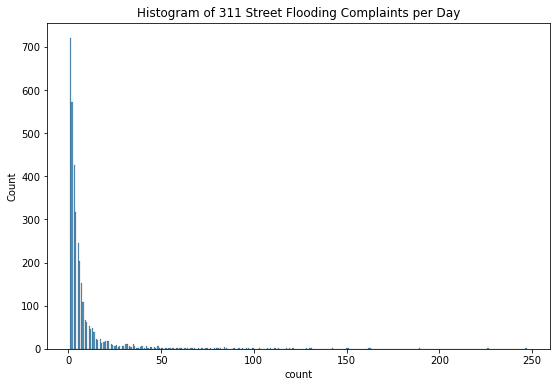

In [1026]:
plt.figure(figsize=(9,6))

sns.histplot(flooding_311_daily)
plt.title('Histogram of 311 Street Flooding Complaints per Day')

In [1027]:
flooding_311_daily.describe()

count   3441.00
mean       7.97
std       15.75
min        1.00
25%        2.00
50%        4.00
75%        7.00
max      247.00
Name: count, dtype: float64

In [1028]:
flooding_311_daily.sort_values(ascending=False)

year_month_day
2017-05-05   247.00
2014-12-09   226.00
2014-04-30   189.00
2018-04-16   163.00
2013-05-08   162.00
              ...  
2020-10-25      NaN
2020-11-04      NaN
2020-11-08      NaN
2020-12-12      NaN
2020-12-19      NaN
Name: count, Length: 4017, dtype: float64

In [1029]:
flooding_311_daily.value_counts(dropna=False)

1.00      720
NaN       576
2.00      571
3.00      425
4.00      317
         ... 
61.00       1
111.00      1
103.00      1
189.00      1
54.00       1
Name: count, Length: 105, dtype: int64

## 6.3 Resampling

A better way to extract different frequencies is to resample data based on daily observations. This is how I'll plot the subsequent figures.

In [1030]:
print(flooding_311.shape)
flooding_311.head()

(27417, 34)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,location,incident_address,street_name,cross_street_1,cross_street_2,bbl,year,year_month_day,year_month,year_month_week
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,"{'latitude': '40.61622473490424', 'longitude':...",AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010,2010-11-29,2010-11-01,2010-12-05
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,NaN,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018,2018-03-04,2018-03-01,2018-03-04
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,"{'latitude': '40.60226417502854', 'longitude':...",111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010,2010-12-18,2010-12-01,2010-12-19
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,"{'latitude': '40.688417629825395', 'longitude'...",95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010,2010-12-22,2010-12-01,2010-12-26
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,"{'latitude': '40.796720571511926', 'longitude'...",NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010,2010-12-26,2010-12-01,2010-12-26


In [1031]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()
flooding_311_daily.rename(index="count", inplace=True)

flooding_311_daily

year_month_day
2010-01-02     3
2010-01-04     1
2010-01-05     1
2010-01-06     4
2010-01-07     3
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Name: count, Length: 3441, dtype: int64

In [1032]:
flooding_311_daily.resample('D').sum()

year_month_day
2010-01-02     3
2010-01-03     0
2010-01-04     1
2010-01-05     1
2010-01-06     4
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Freq: D, Name: count, Length: 4017, dtype: int64

In [1033]:
# A one-liner but difficult to read the chained methods
flooding_311.groupby(by='year_month_day')['unique_key'].count().resample('D').sum()

year_month_day
2010-01-02     3
2010-01-03     0
2010-01-04     1
2010-01-05     1
2010-01-06     4
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Freq: D, Name: unique_key, Length: 4017, dtype: int64

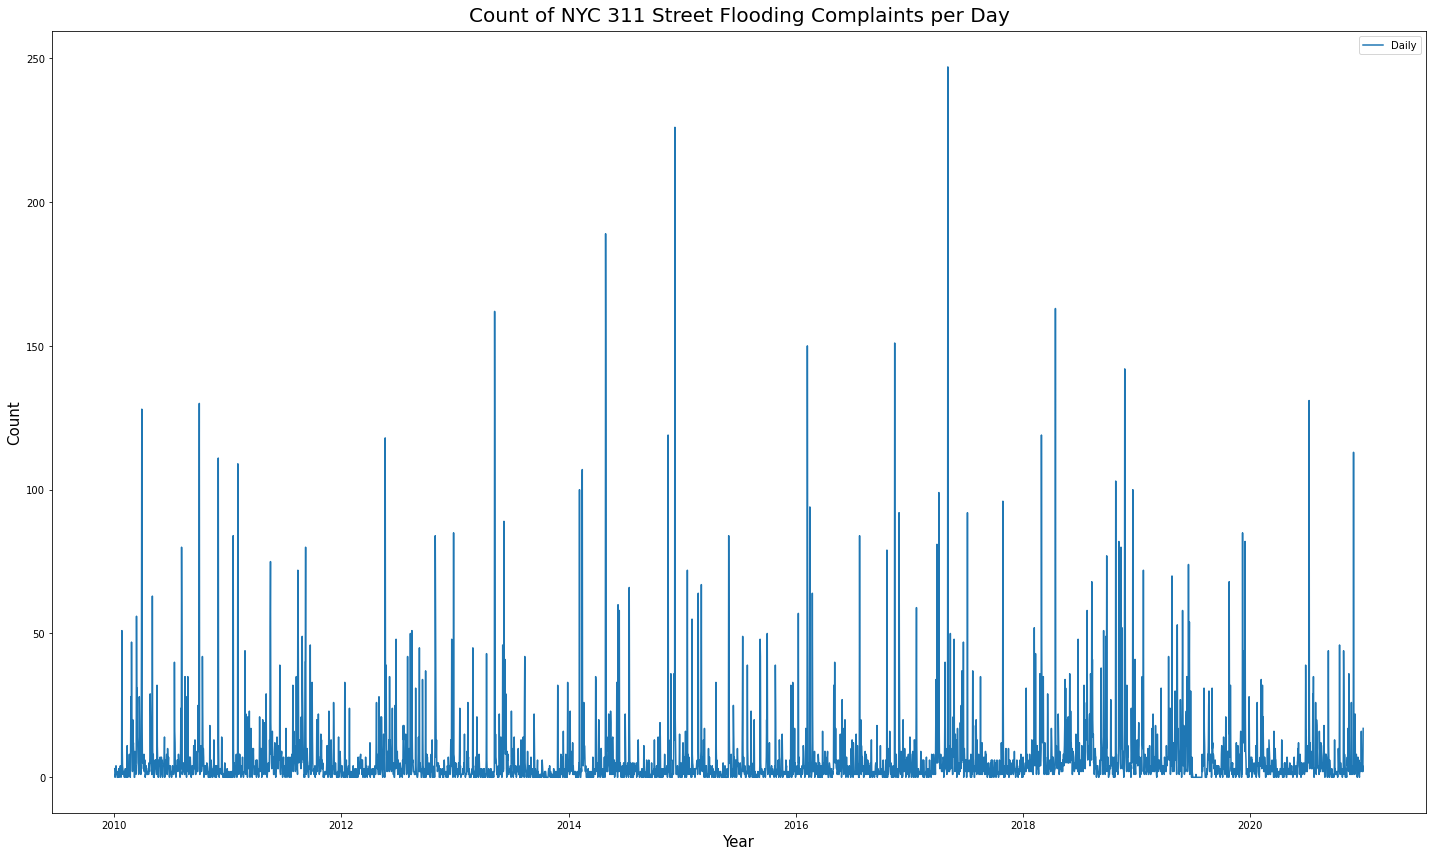

In [1034]:
plt.figure(figsize=(20,12))

sns.lineplot(data=flooding_311_daily.resample('D').sum(), 
             label='Daily')

plt.title('Count of NYC 311 Street Flooding Complaints per Day', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1035]:
flooding_311_daily.resample('Y').sum()

year_month_day
2010-12-31    2531
2011-12-31    2641
2012-12-31    2203
2013-12-31    1664
2014-12-31    2498
2015-12-31    1839
2016-12-31    2262
2017-12-31    2532
2018-12-31    4138
2019-12-31    2967
2020-12-31    2142
Freq: A-DEC, Name: count, dtype: int64

In [1036]:
flooding_311_daily.resample('YS').sum()

year_month_day
2010-01-01    2531
2011-01-01    2641
2012-01-01    2203
2013-01-01    1664
2014-01-01    2498
2015-01-01    1839
2016-01-01    2262
2017-01-01    2532
2018-01-01    4138
2019-01-01    2967
2020-01-01    2142
Freq: AS-JAN, Name: count, dtype: int64

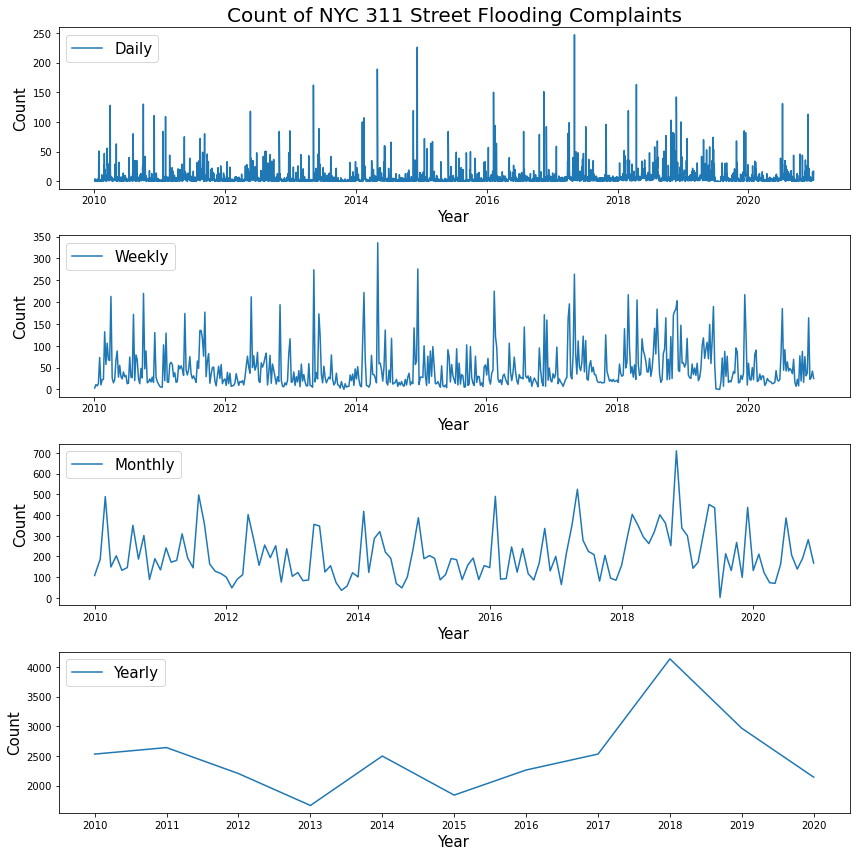

In [1037]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(12,12))

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

sns.lineplot(data=flooding_311_daily.resample('D').sum(), 
             label='Daily', 
             ax=ax1)
sns.lineplot(data=flooding_311_daily.resample('W').sum(), 
             label='Weekly', 
             ax=ax2)

sns.lineplot(data=flooding_311_daily.resample('MS').sum(), 
             label='Monthly', 
             ax=ax3)

sns.lineplot(data=flooding_311_daily.resample('YS').sum(), 
             label='Yearly', 
             ax=ax4) 

ax1.set_title('Count of NYC 311 Street Flooding Complaints', 
              fontsize=20)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_ylabel('Count', fontsize=15) 
    lst[i].set_xlabel('Year', fontsize=15)
    lst[i].legend(loc=2, fontsize=15)

plt.tight_layout()
plt.savefig('figures/pres-8.png')

In [1038]:
flooding_311_daily.resample('D').sum()

year_month_day
2010-01-02     3
2010-01-03     0
2010-01-04     1
2010-01-05     1
2010-01-06     4
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Freq: D, Name: count, Length: 4017, dtype: int64

In [1039]:
flooding_311_daily.index

DatetimeIndex(['2010-01-02', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-09', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='year_month_day', length=3441, freq=None)

In [1040]:
print(flooding_311_daily.resample('D').sum().reset_index().head(), '\n')
print(flooding_311_daily.resample('W').sum().reset_index().head(), '\n')
print(flooding_311_daily.resample('MS').sum().reset_index().head(), '\n')
print(flooding_311_daily.resample('YS').sum().reset_index().head())

  year_month_day  count
0     2010-01-02      3
1     2010-01-03      0
2     2010-01-04      1
3     2010-01-05      1
4     2010-01-06      4 

  year_month_day  count
0     2010-01-03      3
1     2010-01-10     11
2     2010-01-17      8
3     2010-01-24     13
4     2010-01-31     73 

  year_month_day  count
0     2010-01-01    108
1     2010-02-01    187
2     2010-03-01    489
3     2010-04-01    149
4     2010-05-01    203 

  year_month_day  count
0     2010-01-01   2531
1     2011-01-01   2641
2     2012-01-01   2203
3     2013-01-01   1664
4     2014-01-01   2498


# Saving Data

In [1041]:
flooding_311_daily.resample('D').sum().reset_index().to_csv('data-output/flooding_311_daily_resample_D.csv', index=False)
flooding_311_daily.resample('W').sum().reset_index().to_csv('data-output/flooding_311_daily_resample_W.csv', index=False)
flooding_311_daily.resample('MS').sum().reset_index().to_csv('data-output/flooding_311_daily_resample_MS.csv', index=False)
flooding_311_daily.resample('YS').sum().reset_index().to_csv('data-output/flooding_311_daily_resample_YS.csv', index=False)

In [1042]:
print(pd.read_csv('data-output/flooding_311_daily_resample_D.csv').shape)
pd.read_csv('data-output/flooding_311_daily_resample_D.csv').head()

(4017, 2)


,year_month_day,count
0,2010-01-02,3
1,2010-01-03,0
2,2010-01-04,1
3,2010-01-05,1
4,2010-01-06,4


In [1043]:
print(pd.read_csv('data-output/flooding_311_daily_resample_W.csv').shape)
pd.read_csv('data-output/flooding_311_daily_resample_W.csv').head()

(575, 2)


,year_month_day,count
0,2010-01-03,3
1,2010-01-10,11
2,2010-01-17,8
3,2010-01-24,13
4,2010-01-31,73


In [1044]:
print(pd.read_csv('data-output/flooding_311_daily_resample_MS.csv').shape)
pd.read_csv('data-output/flooding_311_daily_resample_MS.csv').head()

(132, 2)


,year_month_day,count
0,2010-01-01,108
1,2010-02-01,187
2,2010-03-01,489
3,2010-04-01,149
4,2010-05-01,203


In [1045]:
print(pd.read_csv('data-output/flooding_311_daily_resample_YS.csv').shape)
pd.read_csv('data-output/flooding_311_daily_resample_YS.csv').head()

(11, 2)


,year_month_day,count
0,2010-01-01,2531
1,2011-01-01,2641
2,2012-01-01,2203
3,2013-01-01,1664
4,2014-01-01,2498


## 6.4 Seasonality

In [1046]:
flooding_311['month'] = flooding_311['created_date'].dt.month

In [1047]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,incident_address,street_name,cross_street_1,cross_street_2,bbl,year,year_month_day,year_month,year_month_week,month
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,AVENUE N,AVENUE N,OCEAN AVENUE,EAST 21 STREET,NaN,2010,2010-11-29,2010-11-01,2010-12-05,11
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,NaN,NaN,ESSEX ST,ATLANTIC AVE,NaN,2018,2018-03-04,2018-03-01,2018-03-04,3
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,111 MEDFORD RD,MEDFORD RD,KEUNE CT,FOREST RD,5008420073.00,2010,2010-12-18,2010-12-01,2010-12-19,12
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,95-20 102 ST,102 ST,95 AVE,97 AVE,4093790013.00,2010,2010-12-22,2010-12-01,2010-12-26,12
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,NaN,NaN,6 AVE,CLINTONVILLE ST,NaN,2010,2010-12-26,2010-12-01,2010-12-26,12


In [1048]:
flooding_311['month'].describe()

count   27417.00
mean        6.53
std         3.34
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        12.00
Name: month, dtype: float64

In [1049]:
flooding_311.groupby(by=['year_month_day'])['unique_key'].count()

year_month_day
2010-01-02     3
2010-01-04     1
2010-01-05     1
2010-01-06     4
2010-01-07     3
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Name: unique_key, Length: 3441, dtype: int64

In [1050]:
seasonality_month = flooding_311.groupby(by=['year_month_day'])['unique_key'].count()
seasonality_month.rename(index="count", inplace=True)

seasonality_month = seasonality_month.reset_index().set_index('year_month_day')
seasonality_month.head()

,count
year_month_day,
2010-01-02,3
2010-01-04,1
2010-01-05,1
2010-01-06,4
2010-01-07,3


In [1051]:
seasonality_month = seasonality_month.resample('MS').sum()

seasonality_month.head()

,count
year_month_day,
2010-01-01,108
2010-02-01,187
2010-03-01,489
2010-04-01,149
2010-05-01,203


In [1052]:
seasonality_month = seasonality_month.reset_index()
seasonality_month['month'] = seasonality_month['year_month_day'].dt.month

seasonality_month.head()

,year_month_day,count,month
0,2010-01-01,108,1
1,2010-02-01,187,2
2,2010-03-01,489,3
3,2010-04-01,149,4
4,2010-05-01,203,5


In [1053]:
seasonality_month.tail()

,year_month_day,count,month
127,2020-08-01,206,8
128,2020-09-01,139,9
129,2020-10-01,191,10
130,2020-11-01,281,11
131,2020-12-01,168,12


In [1054]:
seasonality_month[['month']].describe()

,month
count,132.00
mean,6.50
std,3.47
min,1.00
25%,3.75
50%,6.50
75%,9.25
max,12.00


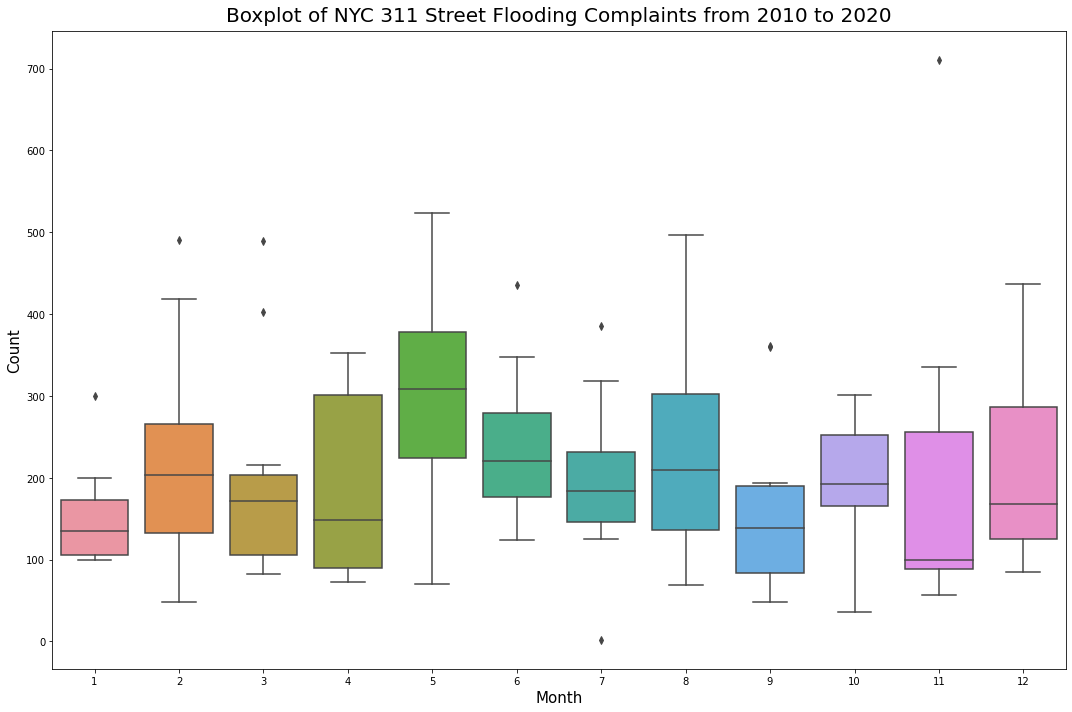

In [1055]:
plt.figure(figsize=(15,10))

sns.boxplot(data=seasonality_month,
            x='month',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=20,
          pad=10)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1056]:
flooding_311['quarter'] = flooding_311['created_date'].dt.quarter

seasonality_quarter = flooding_311.groupby(by=['year_month_day'])['unique_key'].count()
seasonality_quarter.rename(index="count", inplace=True)

seasonality_quarter = seasonality_quarter.reset_index().set_index('year_month_day')
seasonality_quarter.head()

,count
year_month_day,
2010-01-02,3
2010-01-04,1
2010-01-05,1
2010-01-06,4
2010-01-07,3


In [1057]:
seasonality_quarter = seasonality_quarter.resample('QS').sum()

seasonality_quarter.head()

,count
year_month_day,
2010-01-01,784
2010-04-01,485
2010-07-01,683
2010-10-01,579
2011-01-01,548


In [1058]:
seasonality_quarter = seasonality_quarter.reset_index()
seasonality_quarter['quarter'] = seasonality_quarter['year_month_day'].dt.quarter

seasonality_quarter.head()

,year_month_day,count,quarter
0,2010-01-01,784,1
1,2010-04-01,485,2
2,2010-07-01,683,3
3,2010-10-01,579,4
4,2011-01-01,548,1


In [1059]:
seasonality_quarter[['quarter']].describe()

,quarter
count,44.00
mean,2.50
std,1.13
min,1.00
25%,1.75
50%,2.50
75%,3.25
max,4.00


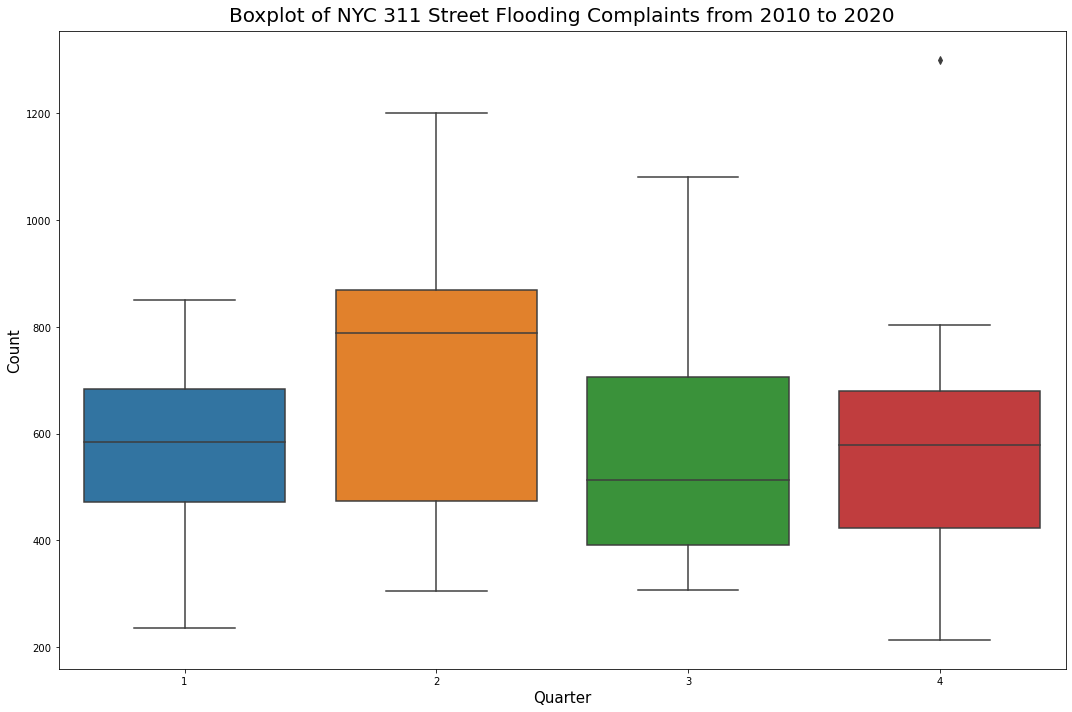

In [1060]:
plt.figure(figsize=(15,10))

sns.boxplot(data=seasonality_quarter,
            x='quarter',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=20,
          pad=10)
plt.xlabel('Quarter', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1061]:
flooding_311['week_of_year'] = flooding_311['created_date'].dt.weekofyear

seasonality_week = flooding_311.groupby(by=['year_month_day'])['unique_key'].count()
seasonality_week.rename(index="count", inplace=True)

seasonality_week = seasonality_week.reset_index().set_index('year_month_day')
seasonality_week.head()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


,count
year_month_day,
2010-01-02,3
2010-01-04,1
2010-01-05,1
2010-01-06,4
2010-01-07,3


In [1062]:
seasonality_week = seasonality_week.resample('W').sum()

seasonality_week.head()

,count
year_month_day,
2010-01-03,3
2010-01-10,11
2010-01-17,8
2010-01-24,13
2010-01-31,73


In [1063]:
seasonality_week = seasonality_week.reset_index()
seasonality_week['week_of_year'] = seasonality_week['year_month_day'].dt.weekofyear

seasonality_week.head()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,year_month_day,count,week_of_year
0,2010-01-03,3,53
1,2010-01-10,11,1
2,2010-01-17,8,2
3,2010-01-24,13,3
4,2010-01-31,73,4


In [1064]:
seasonality_week[['week_of_year']].describe()

,week_of_year
count,575.00
mean,26.64
std,15.10
min,1.00
25%,14.00
50%,27.00
75%,40.00
max,53.00


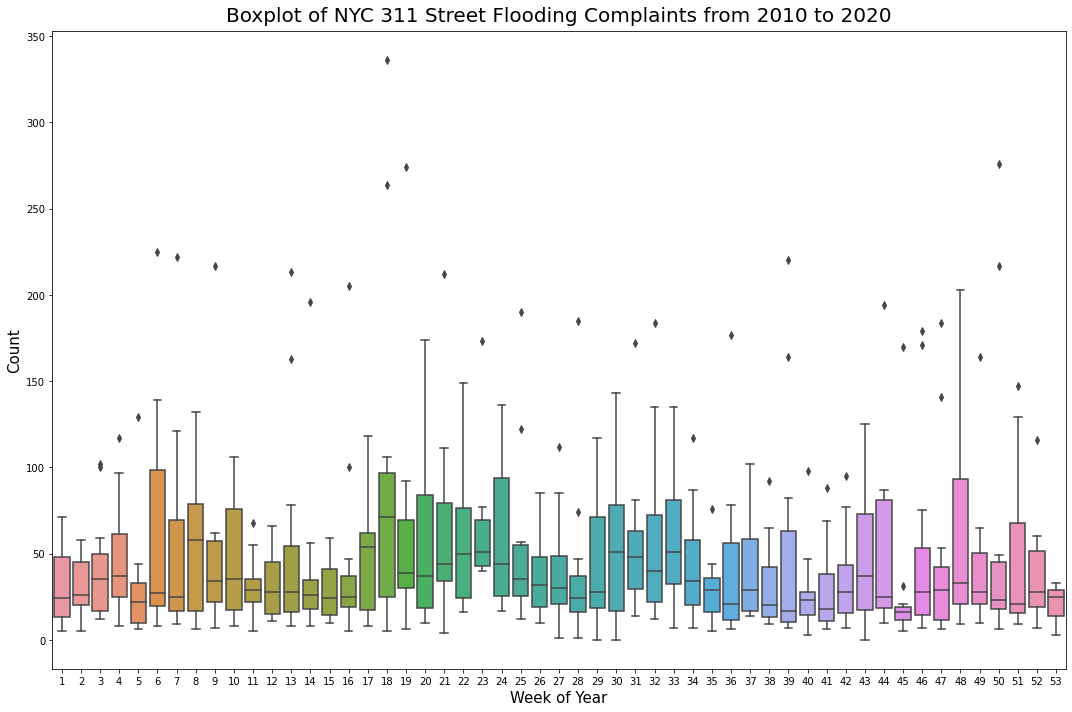

In [1065]:
plt.figure(figsize=(15,10))

sns.boxplot(data=seasonality_week,
            x='week_of_year',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=20,
          pad=10)
plt.xlabel('Week of Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1066]:
flooding_311['day'] = flooding_311['created_date'].dt.day 

seasonality_day = flooding_311.groupby(by=['year_month_day'])['unique_key'].count()
seasonality_day.rename(index="count", inplace=True)

seasonality_day = seasonality_day.reset_index().set_index('year_month_day')
seasonality_day.head()

,count
year_month_day,
2010-01-02,3
2010-01-04,1
2010-01-05,1
2010-01-06,4
2010-01-07,3


In [1067]:
seasonality_day = seasonality_day.resample('d').sum()

seasonality_day.head()

,count
year_month_day,
2010-01-02,3
2010-01-03,0
2010-01-04,1
2010-01-05,1
2010-01-06,4


In [1068]:
seasonality_day = seasonality_day.reset_index()
seasonality_day['day'] = seasonality_day['year_month_day'].dt.day

seasonality_day.head()

,year_month_day,count,day
0,2010-01-02,3,2
1,2010-01-03,0,3
2,2010-01-04,1,4
3,2010-01-05,1,5
4,2010-01-06,4,6


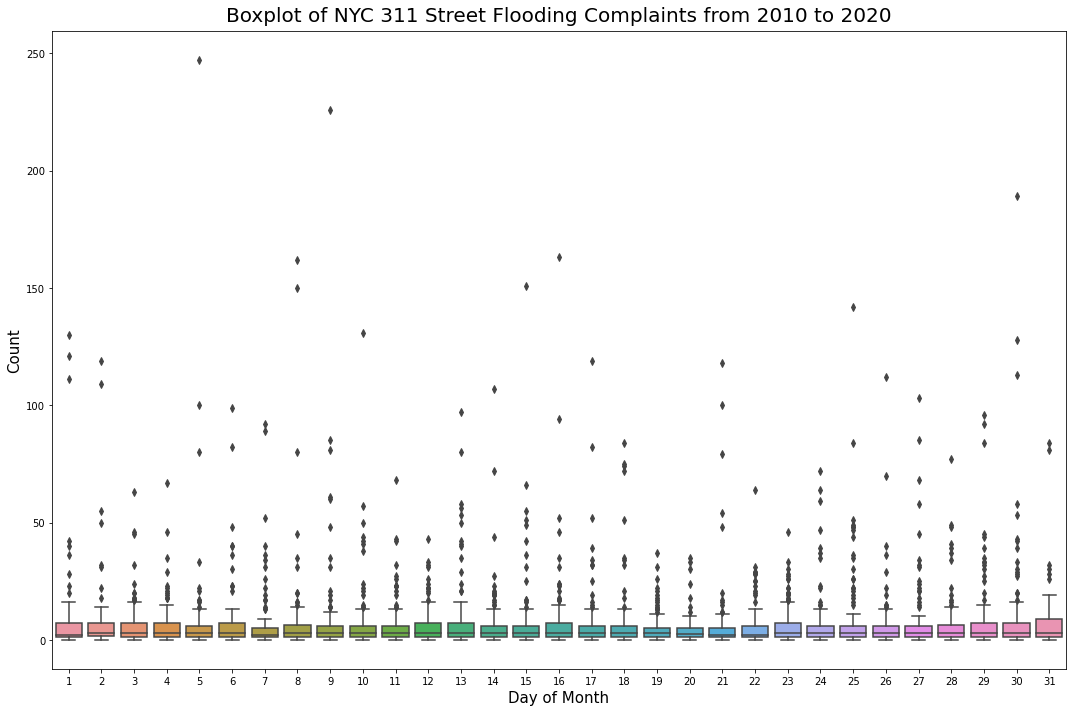

In [1069]:
plt.figure(figsize=(15,10))

sns.boxplot(data=seasonality_day,
            x='day',
            y='count')

plt.title('Boxplot of NYC 311 Street Flooding Complaints from 2010 to 2020', 
          fontsize=20,
          pad=10)
plt.xlabel('Day of Month', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

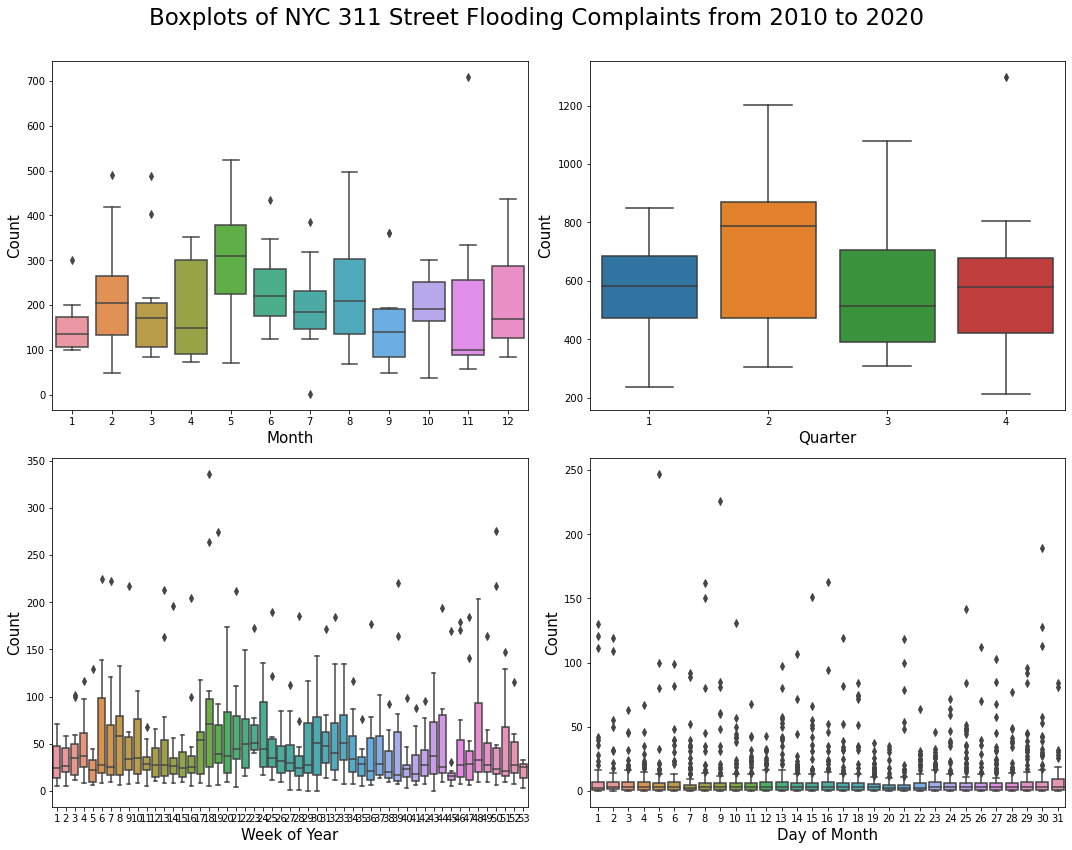

In [1070]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))

sns.boxplot(data=seasonality_month,
            x='month',
            y='count',
            ax=axs[0,0])
axs[0,0].set_xlabel('Month', fontsize=15)

sns.boxplot(data=seasonality_quarter,
            x='quarter',
            y='count',
            ax=axs[0,1])
axs[0,1].set_xlabel('Quarter', fontsize=15)

sns.boxplot(data=seasonality_week,
            x='week_of_year',
            y='count',
            ax=axs[1,0])
axs[1,0].set_xlabel('Week of Year', fontsize=15)
sns.boxplot(data=seasonality_day,
            x='day',
            y='count',
            ax=axs[1,1])
axs[1,1].set_xlabel('Day of Month', fontsize=15)

for ax in axs.flat:
    ax.set_ylabel('Count', fontsize=15)

fig.suptitle('Boxplots of NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=23)

plt.tight_layout()
plt.savefig('figures/pres-9.png')

# 6.5 Resampling for Frequency Average

In [1071]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()
flooding_311_daily = flooding_311_daily.resample('D').sum()
flooding_311_daily.rename(index="count", inplace=True)

flooding_311_daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [1072]:
weekly_mean = flooding_311_daily.resample('W').mean()
monthly_mean = flooding_311_daily.resample('MS').mean()
yearly_mean = flooding_311_daily.resample('YS').mean()

In [1073]:
weekly_mean.head()

year_month_day
2010-01-03    1.50
2010-01-10    1.57
2010-01-17    1.14
2010-01-24    1.86
2010-01-31   10.43
Freq: W-SUN, Name: count, dtype: float64

In [1074]:
monthly_mean.head()

year_month_day
2010-01-01    3.60
2010-02-01    6.68
2010-03-01   15.77
2010-04-01    4.97
2010-05-01    6.55
Freq: MS, Name: count, dtype: float64

In [1075]:
yearly_mean.head()

year_month_day
2010-01-01   6.95
2011-01-01   7.24
2012-01-01   6.02
2013-01-01   4.56
2014-01-01   6.84
Freq: AS-JAN, Name: count, dtype: float64

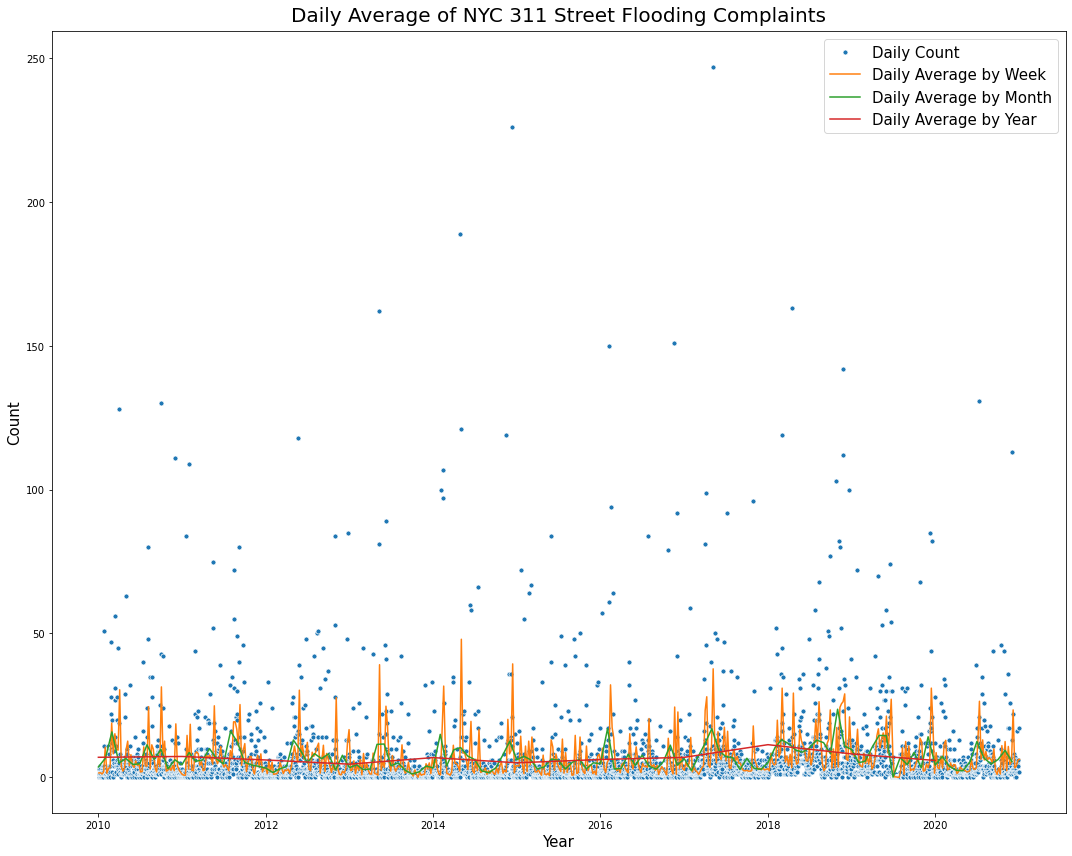

In [1076]:
plt.figure(figsize=(15, 12))

sns.lineplot(data=flooding_311_daily, marker='.', markersize=10, linewidth=0, label='Daily Count')
sns.lineplot(data=weekly_mean, label='Daily Average by Week')
sns.lineplot(data=monthly_mean, label='Daily Average by Month')
sns.lineplot(data=yearly_mean, label='Daily Average by Year')

plt.title('Daily Average of NYC 311 Street Flooding Complaints', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()

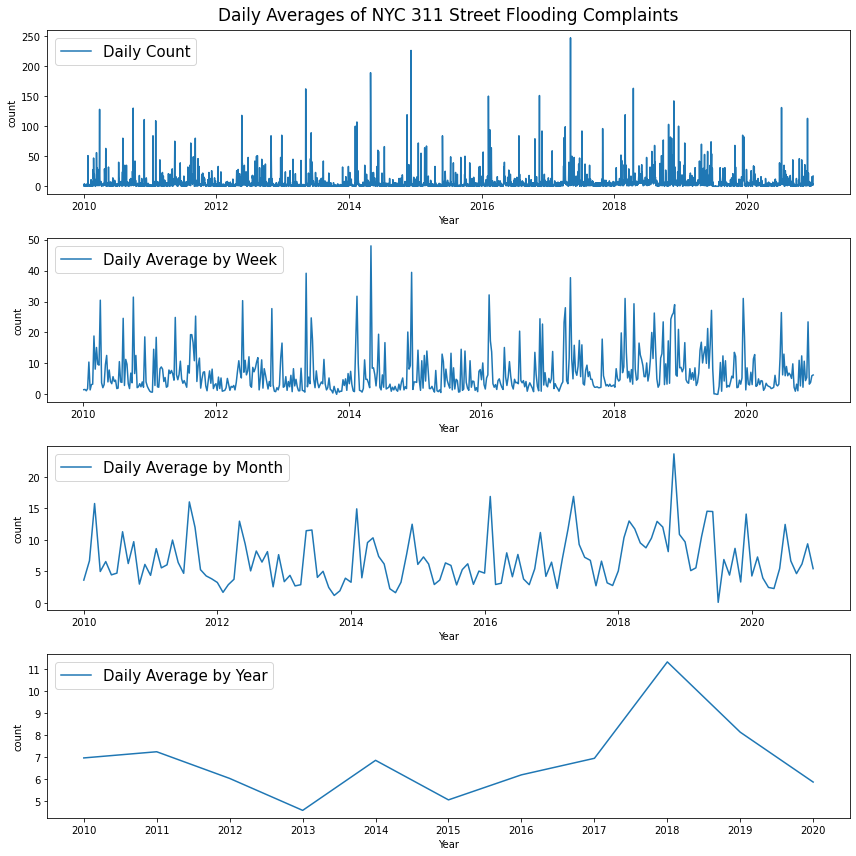

In [1077]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(12,12))

sns.lineplot(data=flooding_311_daily, 
             label='Daily Count', 
             ax=ax1)
sns.lineplot(data=weekly_mean, 
             label='Daily Average by Week', 
             ax=ax2)
sns.lineplot(data=monthly_mean, 
             label='Daily Average by Month', 
             ax=ax3)
sns.lineplot(data=yearly_mean, 
             label='Daily Average by Year', 
             ax=ax4)

ax1.set_title('Daily Averages of NYC 311 Street Flooding Complaints', 
              fontsize=17, 
              pad=10)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_xlabel('Year')
    lst[i].legend(loc=2, fontsize=15)
    
plt.tight_layout()

# 6.6 Rolling Averages

In [1078]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()
flooding_311_daily = flooding_311_daily.resample('D').sum()
flooding_311_daily.rename(index="count", inplace=True)

flooding_311_daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

In [1079]:
flooding_311_daily.rolling(7).mean().head(10)

year_month_day
2010-01-02    NaN
2010-01-03    NaN
2010-01-04    NaN
2010-01-05    NaN
2010-01-06    NaN
2010-01-07    NaN
2010-01-08   1.86
2010-01-09   1.57
2010-01-10   1.57
2010-01-11   1.43
Freq: D, Name: count, dtype: float64

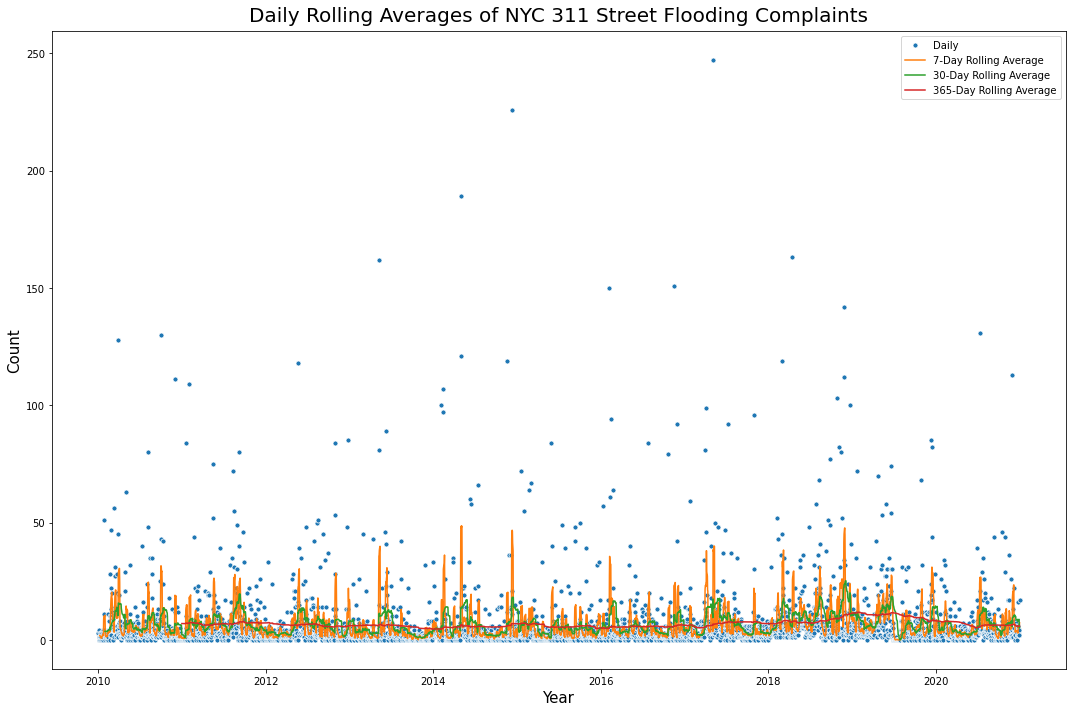

In [1080]:
plt.figure(figsize=(15,10))

sns.lineplot(data=flooding_311_daily, marker='.', markersize=10, linewidth=0, label='Daily')
sns.lineplot(data=flooding_311_daily.rolling(7).mean(), label='7-Day Rolling Average')
sns.lineplot(data=flooding_311_daily.rolling(30).mean(), label='30-Day Rolling Average')
sns.lineplot(data=flooding_311_daily.rolling(365).mean(), label='365-Day Rolling Average')

plt.title('Daily Rolling Averages of NYC 311 Street Flooding Complaints', 
          fontsize=20,
          pad=10)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

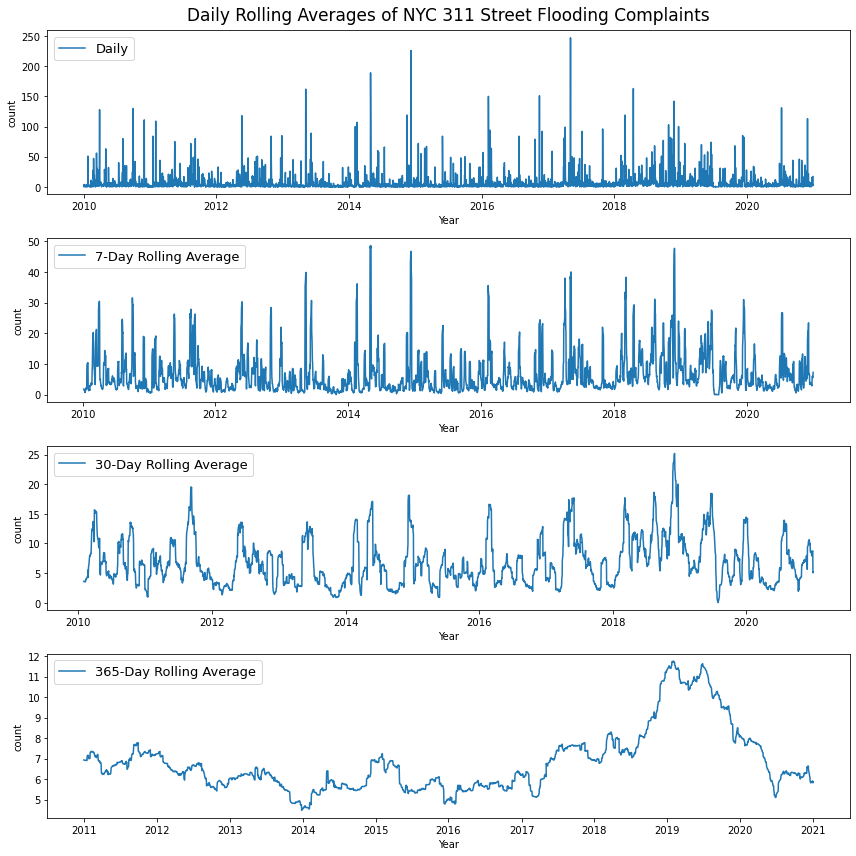

In [1081]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, figsize=(12,12))

sns.lineplot(data=flooding_311_daily, 
             label='Daily', 
             ax=ax1)
sns.lineplot(data=flooding_311_daily.rolling(7).mean(), 
             label='7-Day Rolling Average', 
             ax=ax2)
sns.lineplot(data=flooding_311_daily.rolling(30).mean(), 
             label='30-Day Rolling Average', 
             ax=ax3)
sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax4)

ax1.set_title('Daily Rolling Averages of NYC 311 Street Flooding Complaints', 
              fontsize=17, 
              pad=10)

lst = [ax1, ax2, ax3, ax4]
for i in range(len(lst)):
    lst[i].set_xlabel('Year')  
    lst[i].legend(loc=2, fontsize=13)
    
plt.tight_layout()    
plt.savefig('figures/pres-10.png')

## 6.7 Additional Time Series Analysis

In [1082]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,cross_street_2,bbl,year,year_month_day,year_month,year_month_week,month,quarter,week_of_year,day
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,EAST 21 STREET,NaN,2010,2010-11-29,2010-11-01,2010-12-05,11,4,48,29
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,ATLANTIC AVE,NaN,2018,2018-03-04,2018-03-01,2018-03-04,3,1,9,4
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,FOREST RD,5008420073.00,2010,2010-12-18,2010-12-01,2010-12-19,12,4,50,18
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,97 AVE,4093790013.00,2010,2010-12-22,2010-12-01,2010-12-26,12,4,51,22
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,CLINTONVILLE ST,NaN,2010,2010-12-26,2010-12-01,2010-12-26,12,4,51,26


In [1083]:
flooding_311['day_name'] = flooding_311['created_date'].dt.day_name()

flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,bbl,year,year_month_day,year_month,year_month_week,month,quarter,week_of_year,day,day_name
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,NaN,2010,2010-11-29,2010-11-01,2010-12-05,11,4,48,29,Monday
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,NaN,2018,2018-03-04,2018-03-01,2018-03-04,3,1,9,4,Sunday
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,5008420073.00,2010,2010-12-18,2010-12-01,2010-12-19,12,4,50,18,Saturday
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,4093790013.00,2010,2010-12-22,2010-12-01,2010-12-26,12,4,51,22,Wednesday
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,NaN,2010,2010-12-26,2010-12-01,2010-12-26,12,4,51,26,Sunday


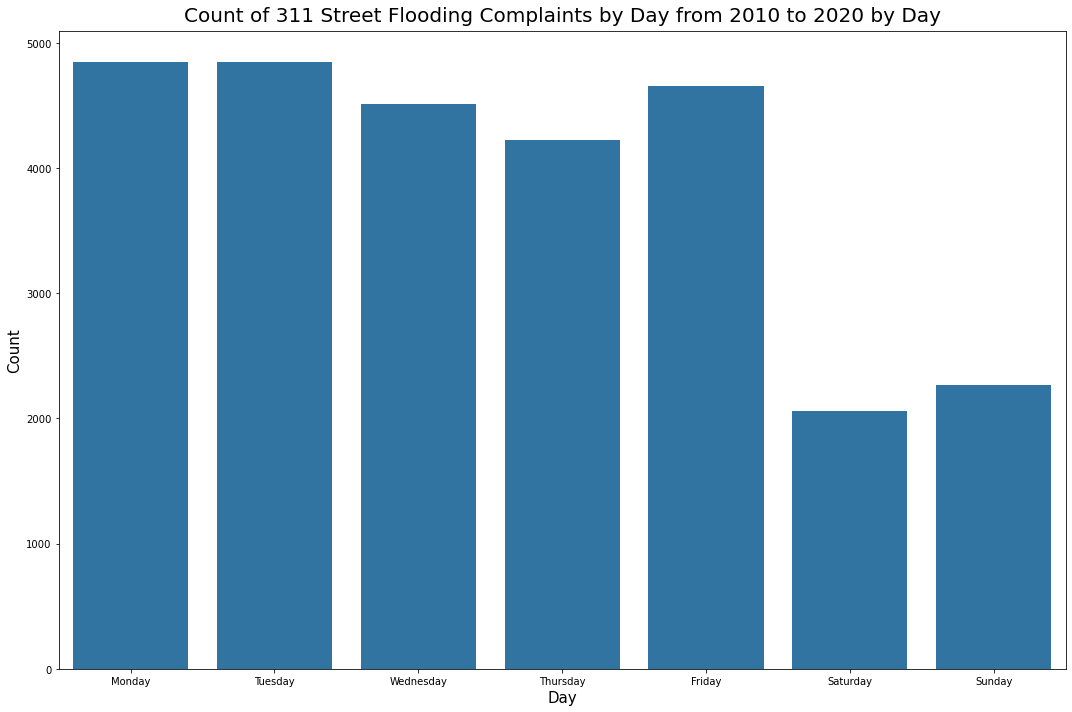

In [1084]:
plt.figure(figsize=(15,10))

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(x=flooding_311['day_name'],
              color='#1f77b4',
              order=order)

plt.title('Count of 311 Street Flooding Complaints by Day from 2010 to 2020 by Day', 
          fontsize=20,
          pad=10)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1085]:
flooding_311['hour'] = flooding_311['created_date'].dt.hour

flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year,year_month_day,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010,2010-11-29,2010-11-01,2010-12-05,11,4,48,29,Monday,20
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018,2018-03-04,2018-03-01,2018-03-04,3,1,9,4,Sunday,6
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010,2010-12-18,2010-12-01,2010-12-19,12,4,50,18,Saturday,11
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010,2010-12-22,2010-12-01,2010-12-26,12,4,51,22,Wednesday,8
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010,2010-12-26,2010-12-01,2010-12-26,12,4,51,26,Sunday,10


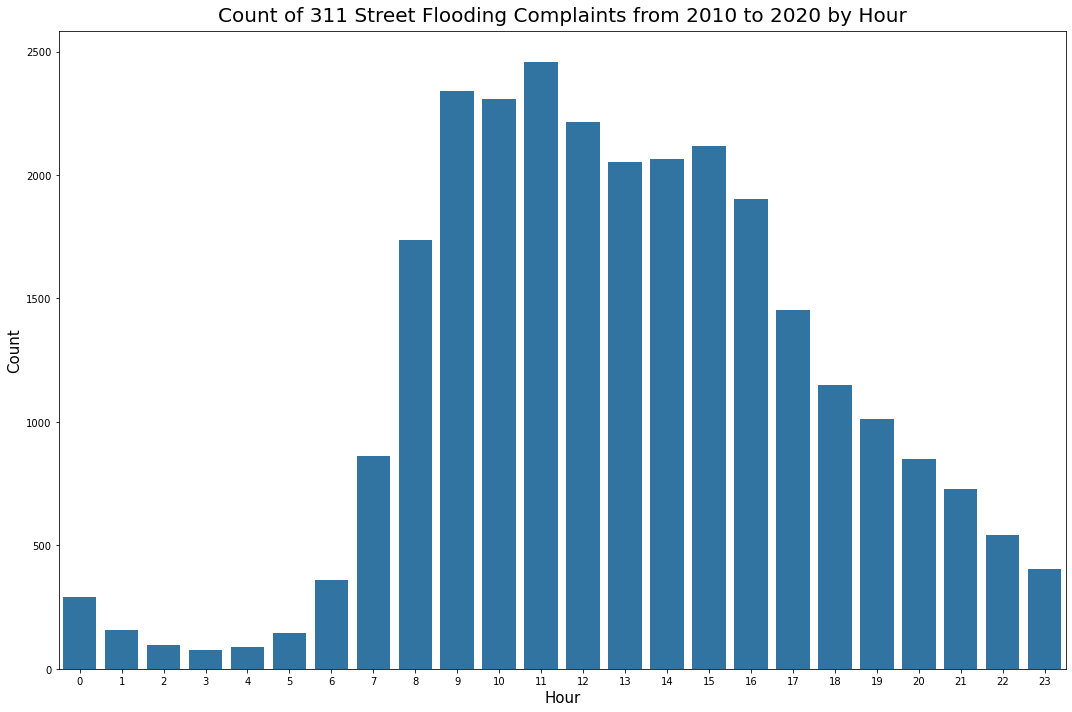

In [1086]:
plt.figure(figsize=(15,10))

sns.countplot(x=flooding_311['hour'],
              color='#1f77b4')

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour', 
          fontsize=20,
          pad=10)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1087]:
flooding_311['time'] = flooding_311['created_date'].dt.time

flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year_month_day,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010-11-29,2010-11-01,2010-12-05,11,4,48,29,Monday,20,20:01:00
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018-03-04,2018-03-01,2018-03-04,3,1,9,4,Sunday,6,06:10:00
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010-12-18,2010-12-01,2010-12-19,12,4,50,18,Saturday,11,11:01:00
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010-12-22,2010-12-01,2010-12-26,12,4,51,22,Wednesday,8,08:39:00
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010-12-26,2010-12-01,2010-12-26,12,4,51,26,Sunday,10,10:44:00


In [1088]:
flooding_time = flooding_311.groupby(by='time')['unique_key'].count()
flooding_time.rename(index="count", inplace=True)
flooding_time = flooding_time.reset_index()

flooding_time.head()

,time,count
0,00:00:00,73
1,00:01:00,6
2,00:02:00,6
3,00:03:00,4
4,00:04:00,6


In [1089]:
flooding_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    1384 non-null   object
 1   count   1384 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB


In [1090]:
flooding_time.time = pd.to_datetime(flooding_time.time, format='%H:%M:%S')
flooding_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1384 non-null   datetime64[ns]
 1   count   1384 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.8 KB


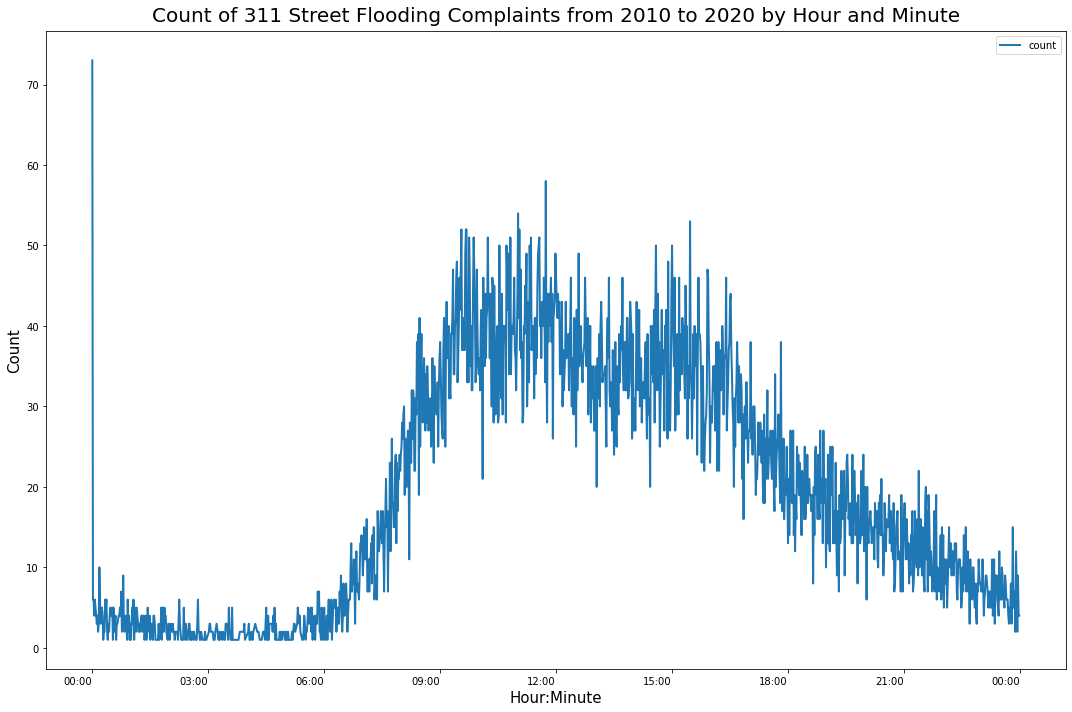

In [1091]:
fig, ax = plt.subplots(figsize=(15,10))

myFmt = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

flooding_time.plot(x='time',
                   y='count',
                   ax=ax, 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour and Minute', 
          fontsize=20,
          pad=10)
plt.xlabel('Hour:Minute', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1092]:
flooding_time.set_index('time', inplace=True)
flooding_time = flooding_time['count'].rolling(15).mean()
flooding_time

time
1900-01-01 00:00:00    NaN
1900-01-01 00:01:00    NaN
1900-01-01 00:02:00    NaN
1900-01-01 00:03:00    NaN
1900-01-01 00:04:00    NaN
                      ... 
1900-01-01 23:55:00   6.20
1900-01-01 23:56:00   5.93
1900-01-01 23:57:00   6.27
1900-01-01 23:58:00   6.33
1900-01-01 23:59:00   6.27
Name: count, Length: 1384, dtype: float64

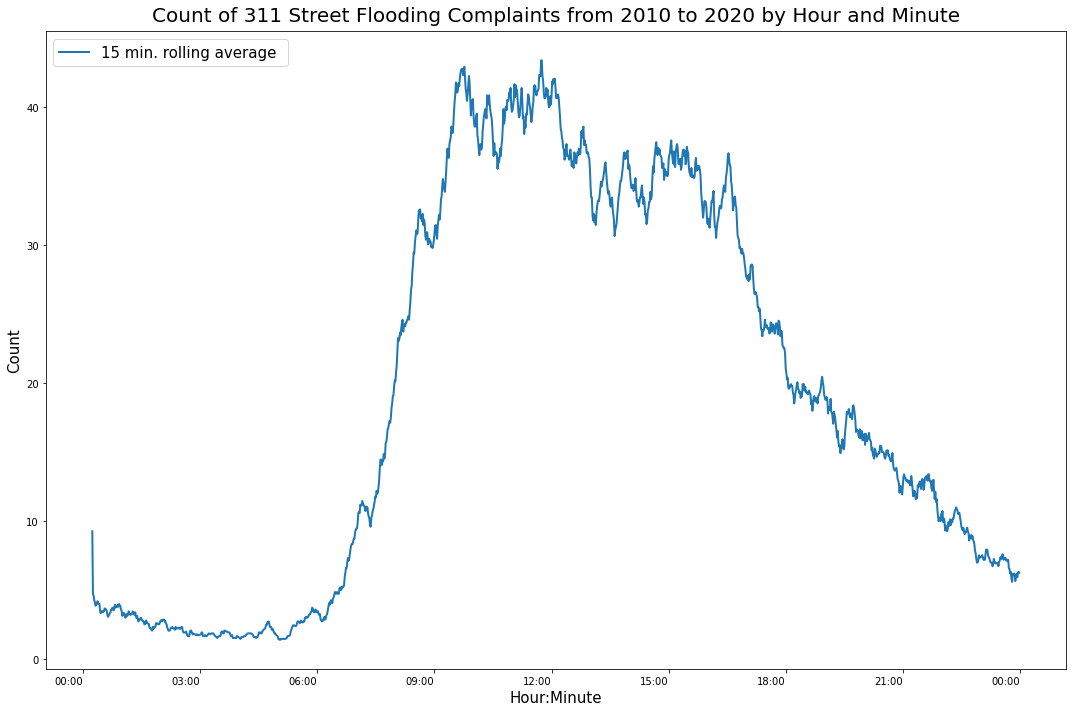

In [1093]:
fig, ax = plt.subplots(figsize=(15,10))

myFmt = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

flooding_time.plot(y='count',
                   ax=ax, 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2,
                   label='15 min. rolling average ', 
                   legend=True)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by Hour and Minute', 
          fontsize=20,
          pad=10)
plt.legend(loc=2, fontsize=15)
plt.xlabel('Hour:Minute', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

In [1094]:
flooding_311['am_pm'] = flooding_311['created_date'].dt.strftime('%p')

flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010-11-01,2010-12-05,11,4,48,29,Monday,20,20:01:00,PM
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018-03-01,2018-03-04,3,1,9,4,Sunday,6,06:10:00,AM
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010-12-01,2010-12-19,12,4,50,18,Saturday,11,11:01:00,AM
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010-12-01,2010-12-26,12,4,51,22,Wednesday,8,08:39:00,AM
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010-12-01,2010-12-26,12,4,51,26,Sunday,10,10:44:00,AM


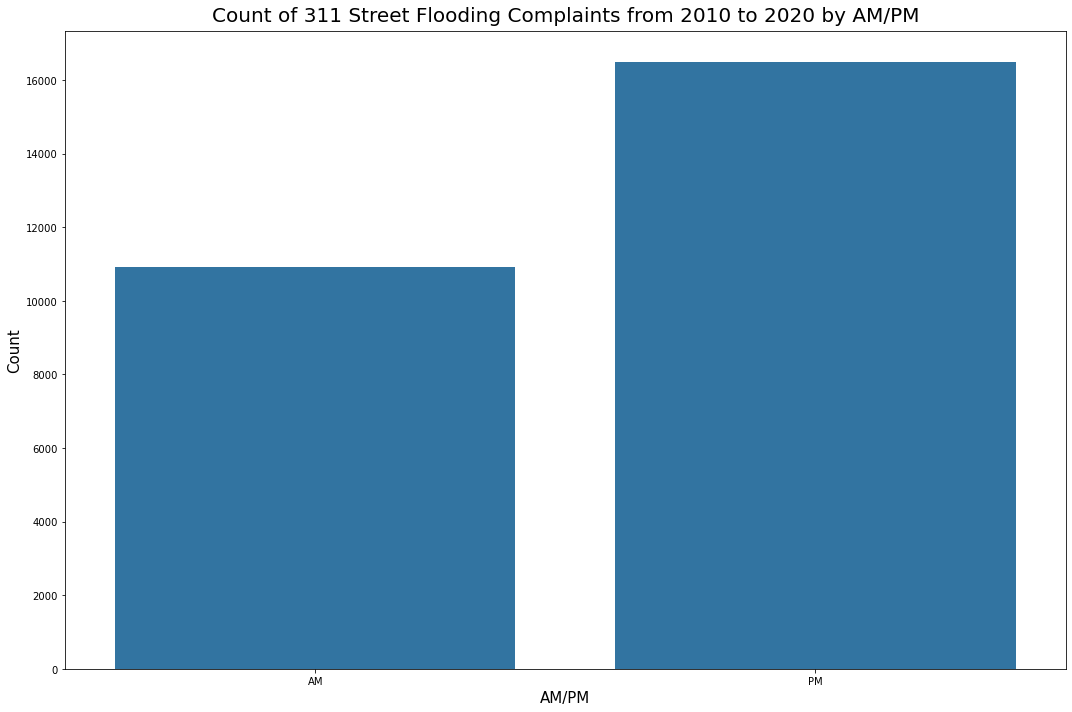

In [1095]:
plt.figure(figsize=(15,10))

order = ['AM', 'PM']

sns.countplot(x=flooding_311['am_pm'],
              color='#1f77b4',
              order=order)

plt.title('Count of 311 Street Flooding Complaints from 2010 to 2020 by AM/PM', 
          fontsize=20,
          pad=10)
plt.xlabel('AM/PM', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()

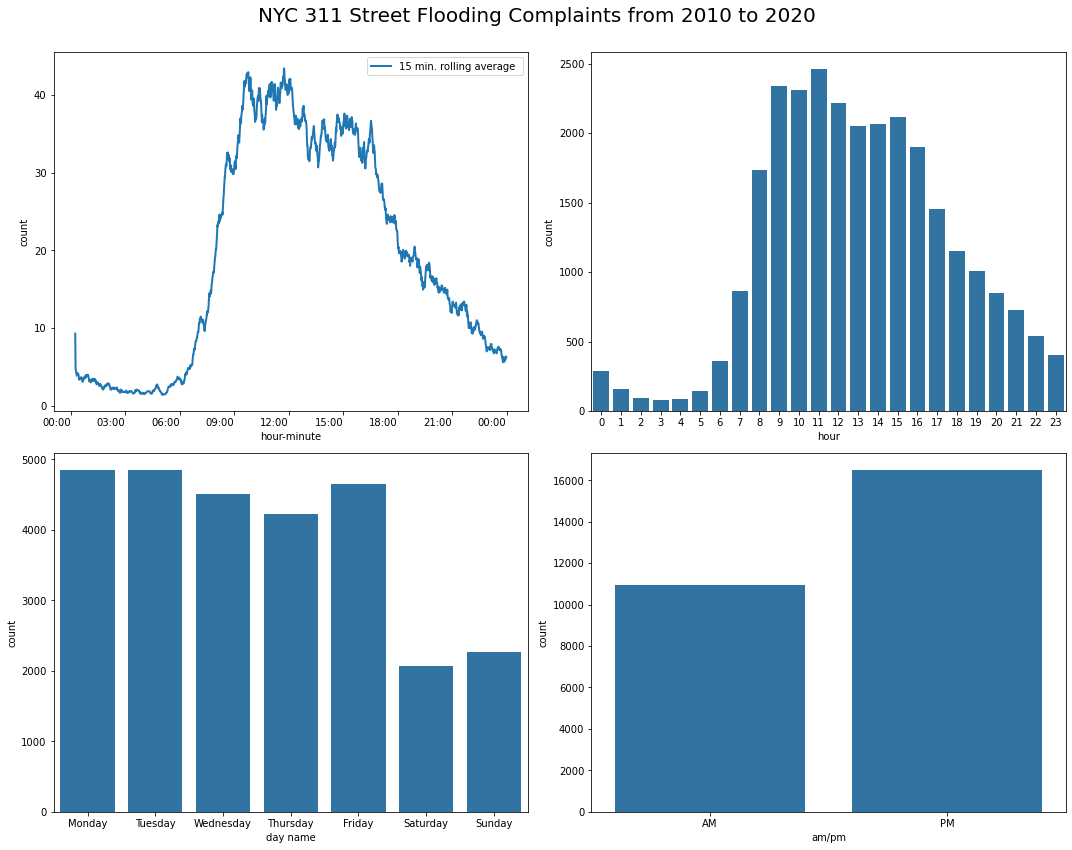

In [1096]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))

myFmt = matplotlib.dates.DateFormatter('%H:%M')
axs[0,0].xaxis.set_major_formatter(myFmt)
flooding_time.plot(x='time',
                   y='count',
                   ax=axs[0,0], 
                   rot=0,
                   color='#1f77b4', 
                   linewidth=2,
                   legend=True,
                   label='15 min. rolling average ')
axs[0,0].set_ylabel('count') 
axs[0,0].set_xlabel('hour-minute')

sns.countplot(x=flooding_311['hour'],
              color='#1f77b4',
              ax=axs[0,1])

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=flooding_311['day_name'],
              color='#1f77b4',
              order=order,
              ax=axs[1,0])
axs[1,0].set_xlabel('day name')

order = ['AM', 'PM']
sns.countplot(x=flooding_311['am_pm'],
              color='#1f77b4',
              order=order,
              ax=axs[1,1])
axs[1,1].set_xlabel('am/pm')

fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=20) 

plt.tight_layout()
plt.savefig('figures/pres-11.png')

# Saving Data

In [1097]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010-11-01,2010-12-05,11,4,48,29,Monday,20,20:01:00,PM
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018-03-01,2018-03-04,3,1,9,4,Sunday,6,06:10:00,AM
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010-12-01,2010-12-19,12,4,50,18,Saturday,11,11:01:00,AM
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010-12-01,2010-12-26,12,4,51,22,Wednesday,8,08:39:00,AM
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010-12-01,2010-12-26,12,4,51,26,Sunday,10,10:44:00,AM


In [1098]:
flooding_311.to_csv('data-output/complaints_with_timeseries_info.csv', index=False)

In [1099]:
print(pd.read_csv('data-output/complaints_with_timeseries_info.csv').shape)
pd.read_csv('data-output/complaints_with_timeseries_info.csv').head()

(27417, 42)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010-11-01 00:00:00,2010-12-05 00:00:00,11,4,48,29,Monday,20,20:01:00,PM
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018-03-01 00:00:00,2018-03-04 00:00:00,3,1,9,4,Sunday,6,06:10:00,AM
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010-12-01 00:00:00,2010-12-19 00:00:00,12,4,50,18,Saturday,11,11:01:00,AM
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010-12-01 00:00:00,2010-12-26 00:00:00,12,4,51,22,Wednesday,8,08:39:00,AM
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010-12-01 00:00:00,2010-12-26 00:00:00,12,4,51,26,Sunday,10,10:44:00,AM


# 7. Anomoly Detection

Count per Frequency Ranked

In [1100]:
flooding_311.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,...,year_month,year_month_week,month,quarter,week_of_year,day,day_name,hour,time,am_pm
0,19224496,2010-11-29 20:01:00,2010-11-30T08:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11210.00,NaN,NaN,...,2010-11-01,2010-12-05,11,4,48,29,Monday,20,20:01:00,PM
1,38610039,2018-03-04 06:10:00,2018-03-07T10:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,ESSEX ST,ATLANTIC AVE,...,2018-03-01,2018-03-04,3,1,9,4,Sunday,6,06:10:00,AM
2,19379336,2010-12-18 11:01:00,2011-01-10T15:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10304.00,NaN,NaN,...,2010-12-01,2010-12-19,12,4,50,18,Saturday,11,11:01:00,AM
3,19406934,2010-12-22 08:39:00,2011-01-03T09:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11416.00,NaN,NaN,...,2010-12-01,2010-12-26,12,4,51,22,Wednesday,8,08:39:00,AM
4,19424458,2010-12-26 10:44:00,2010-12-26T11:55:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11357.00,6 AVE,CLINTONVILLE ST,...,2010-12-01,2010-12-26,12,4,51,26,Sunday,10,10:44:00,AM


In [1101]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()

flooding_311_daily.resample('D').sum().sort_values(ascending=False).head(10).reset_index()

,year_month_day,unique_key
0,2017-05-05,247
1,2014-12-09,226
2,2014-04-30,189
3,2018-04-16,163
4,2013-05-08,162
5,2016-11-15,151
6,2016-02-08,150
7,2018-11-25,142
8,2020-07-10,131
9,2010-10-01,130


In [1102]:
flooding_311_daily.resample('D').sum().sort_values(ascending=False).head(10).reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year_month_day  10 non-null     datetime64[ns]
 1   unique_key      10 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 288.0 bytes


In [1103]:
daily = flooding_311_daily.resample('D').sum().sort_values(ascending=False).head(10).reset_index()
daily.rename(columns={"unique_key": "count"}, 
             inplace=True)

daily['date_formatted'] = daily['year_month_day'].dt.strftime('%Y-%m-%d')

daily.head(10)

,year_month_day,count,date_formatted
0,2017-05-05,247,2017-05-05
1,2014-12-09,226,2014-12-09
2,2014-04-30,189,2014-04-30
3,2018-04-16,163,2018-04-16
4,2013-05-08,162,2013-05-08
5,2016-11-15,151,2016-11-15
6,2016-02-08,150,2016-02-08
7,2018-11-25,142,2018-11-25
8,2020-07-10,131,2020-07-10
9,2010-10-01,130,2010-10-01


In [1104]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year_month_day  10 non-null     datetime64[ns]
 1   count           10 non-null     int64         
 2   date_formatted  10 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 368.0+ bytes


In [1105]:
weekly = flooding_311_daily.resample('W').sum().sort_values(ascending=False).head(10).reset_index()
weekly.rename(columns={"unique_key": "count"}, 
              inplace=True)

weekly['date_formatted'] = weekly.year_month_day.astype(str)

weekly.head(10)

,year_month_day,count,date_formatted
0,2014-05-04,336,2014-05-04
1,2014-12-14,276,2014-12-14
2,2013-05-12,274,2013-05-12
3,2017-05-07,264,2017-05-07
4,2016-02-14,225,2016-02-14
5,2014-02-16,222,2014-02-16
6,2010-10-03,220,2010-10-03
7,2018-03-04,217,2018-03-04
8,2019-12-15,217,2019-12-15
9,2010-04-04,213,2010-04-04


In [1106]:
# sanity check - checking when the weekly frequency stops (Sunday?)

In [1107]:
flooding_311_daily.resample('D').sum().head(10).reset_index()

,year_month_day,unique_key
0,2010-01-02,3
1,2010-01-03,0
2,2010-01-04,1
3,2010-01-05,1
4,2010-01-06,4
5,2010-01-07,3
6,2010-01-08,1
7,2010-01-09,1
8,2010-01-10,0
9,2010-01-11,0


In [1108]:
weekly_sanity_check  = flooding_311_daily.resample('W').sum().head(10).reset_index()

weekly_sanity_check['day_name'] = weekly_sanity_check.year_month_day.dt.day_name()

weekly_sanity_check.head()

,year_month_day,unique_key,day_name
0,2010-01-03,3,Sunday
1,2010-01-10,11,Sunday
2,2010-01-17,8,Sunday
3,2010-01-24,13,Sunday
4,2010-01-31,73,Sunday


In [1109]:
# sanity check - approved. Bins weekly from Monday to Sunday

In [1110]:
monthly = flooding_311_daily.resample('MS').sum().sort_values(ascending=False).head(10).reset_index()
monthly.rename(columns={"unique_key": "count"}, 
               inplace=True)

monthly['date_formatted'] = monthly['year_month_day'].dt.strftime('%Y-%b')

monthly.head()

,year_month_day,count,date_formatted
0,2018-11-01,710,2018-Nov
1,2017-05-01,524,2017-May
2,2011-08-01,497,2011-Aug
3,2016-02-01,490,2016-Feb
4,2010-03-01,489,2010-Mar


In [1111]:
yearly = flooding_311_daily.resample('YS').sum().sort_values(ascending=False).head(10).reset_index()
yearly.rename(columns={"unique_key": "count"}, 
              inplace=True)

yearly['date_formatted'] = yearly['year_month_day'].dt.strftime('%Y')

yearly.head()

,year_month_day,count,date_formatted
0,2018-01-01,4138,2018
1,2019-01-01,2967,2019
2,2011-01-01,2641,2011
3,2017-01-01,2532,2017
4,2010-01-01,2531,2010


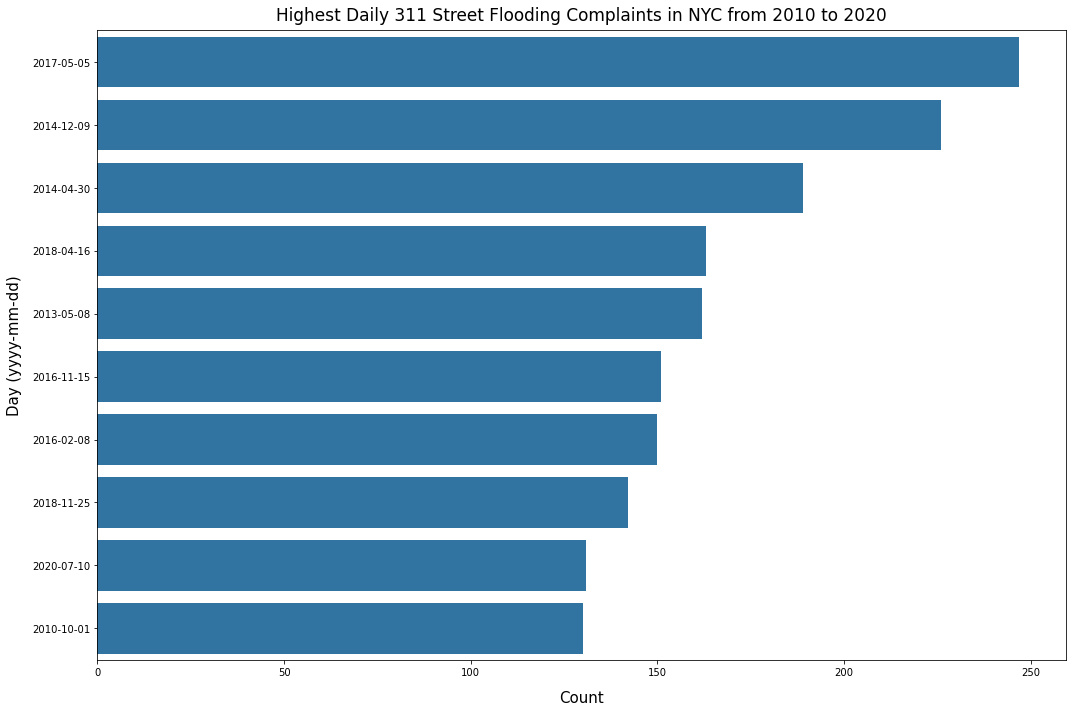

In [1112]:
plt.figure(figsize=(15,10))

sns.barplot(data=daily,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Daily 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=17,
          pad=10)
plt.xlabel('Count', fontsize=15, labelpad=13)
plt.ylabel('Day (yyyy-mm-dd)', fontsize=15, labelpad=10)
plt.tight_layout()

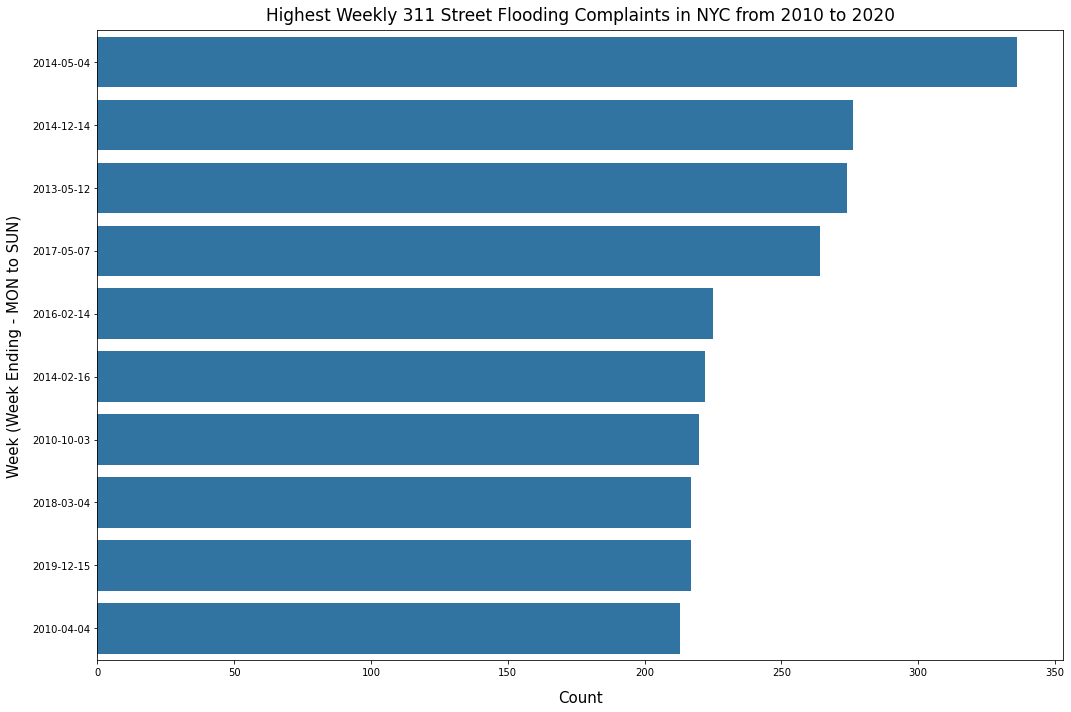

In [1113]:
plt.figure(figsize=(15,10))

sns.barplot(data=weekly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Weekly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=17,
          pad=10)
plt.xlabel('Count', fontsize=15, labelpad=13)
plt.ylabel('Week (Week Ending - MON to SUN)', fontsize=15, labelpad=10)
plt.tight_layout()

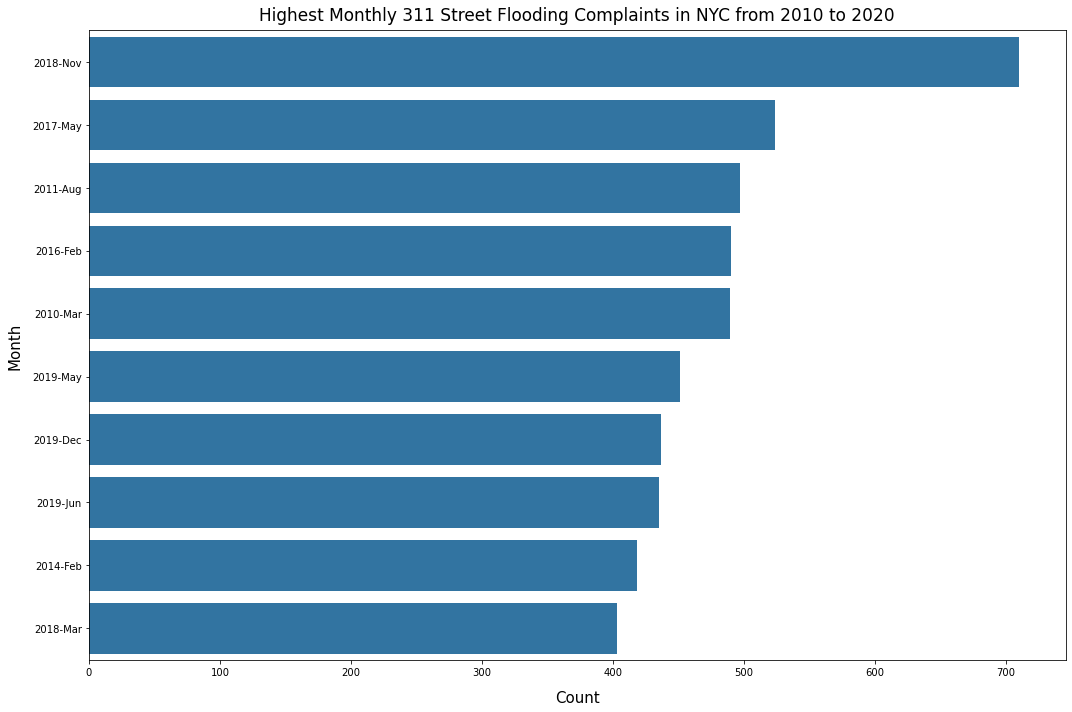

In [1114]:
plt.figure(figsize=(15,10))

sns.barplot(data=monthly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Monthly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=17,
          pad=10)
plt.xlabel('Count', fontsize=15, labelpad=13)
plt.ylabel('Month', fontsize=15, labelpad=10)
plt.tight_layout()

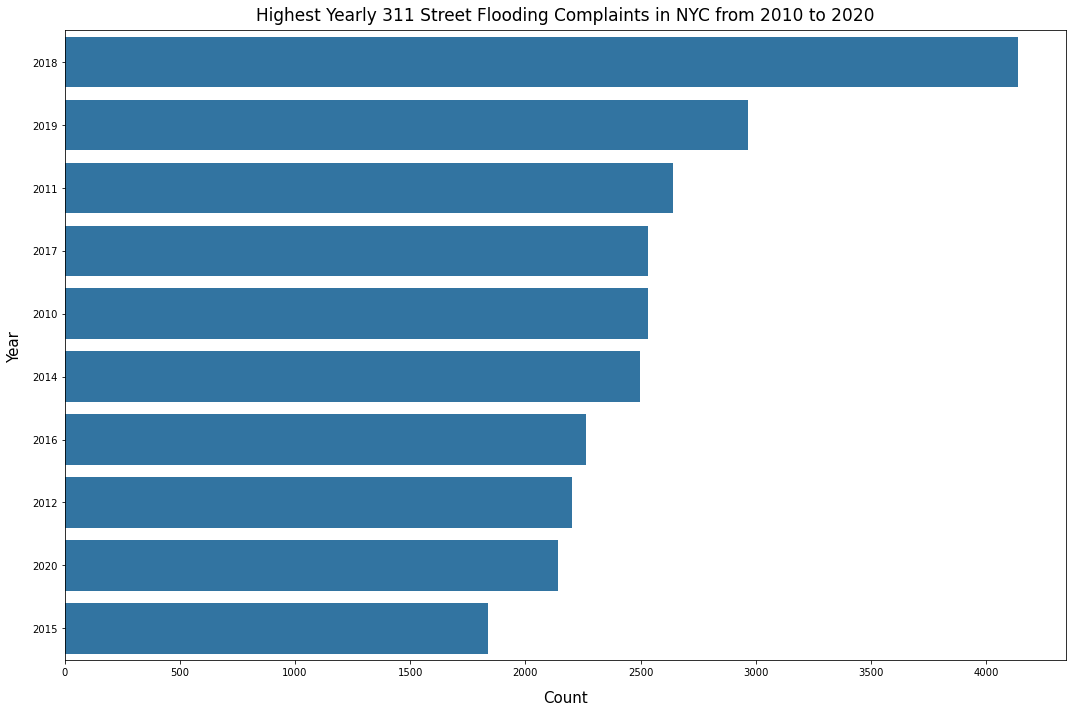

In [1115]:
plt.figure(figsize=(15,10))

sns.barplot(data=yearly,
            y='date_formatted',
            x='count',
            color='#1f77b4')

plt.title('Highest Yearly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
          fontsize=17,
          pad=10)
plt.xlabel('Count', fontsize=15, labelpad=13)
plt.ylabel('Year', fontsize=15, labelpad=10)
plt.tight_layout()

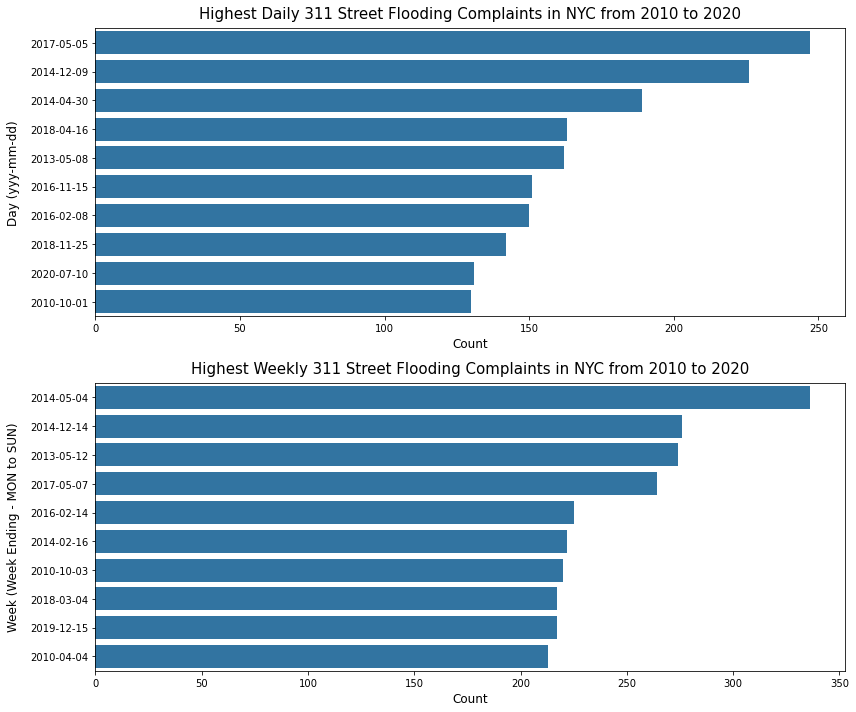

In [1116]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(12, 10))

# first plot
sns.barplot(data=daily,
            y='date_formatted',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Highest Daily 311 Street Flooding Complaints in NYC from 2010 to 2020', 
                  fontsize=15,
                  pad=10)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Day (yyy-mm-dd)', fontsize=12, labelpad=10)

# second plot
sns.barplot(data=weekly,
            y='date_formatted',
            x='count',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Highest Weekly 311 Street Flooding Complaints in NYC from 2010 to 2020', 
                  fontsize=15,
                  pad=10)
axs[1].set_xlabel('Count', fontsize=12)
axs[1].set_ylabel('Week (Week Ending - MON to SUN)', fontsize=12, labelpad=10)

plt.tight_layout()
plt.savefig('figures/pres-12.png')

# 8. Manually Formatting Date Tick Labels

In [1117]:
flooding_311_daily

year_month_day
2010-01-02     3
2010-01-04     1
2010-01-05     1
2010-01-06     4
2010-01-07     3
              ..
2020-12-27     4
2020-12-28     2
2020-12-29     4
2020-12-30     2
2020-12-31    17
Name: unique_key, Length: 3441, dtype: int64

In [1118]:
flooding_311_daily = flooding_311.groupby(by='year_month_day')['unique_key'].count()
flooding_311_daily = flooding_311_daily.resample('D').sum()
flooding_311_daily.rename(index="count", inplace=True)

flooding_311_daily.head(10)

year_month_day
2010-01-02    3
2010-01-03    0
2010-01-04    1
2010-01-05    1
2010-01-06    4
2010-01-07    3
2010-01-08    1
2010-01-09    1
2010-01-10    0
2010-01-11    0
Freq: D, Name: count, dtype: int64

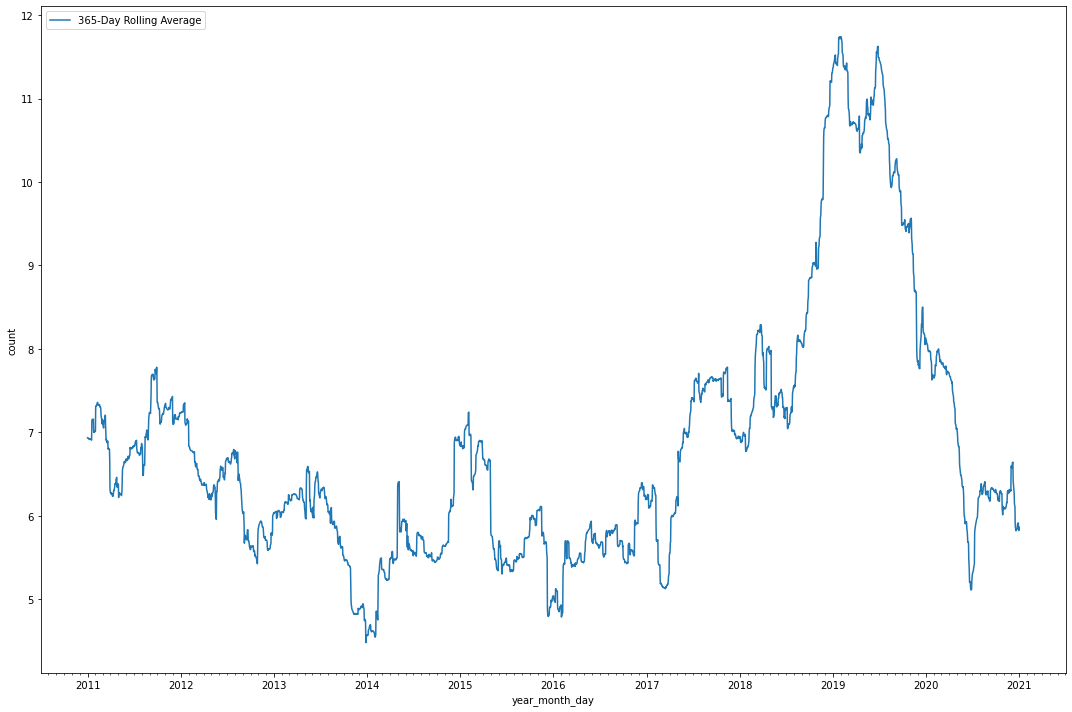

In [1119]:
fig, ax = plt.subplots(figsize=(15,10))

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('figures/x_axis_label_1.png')

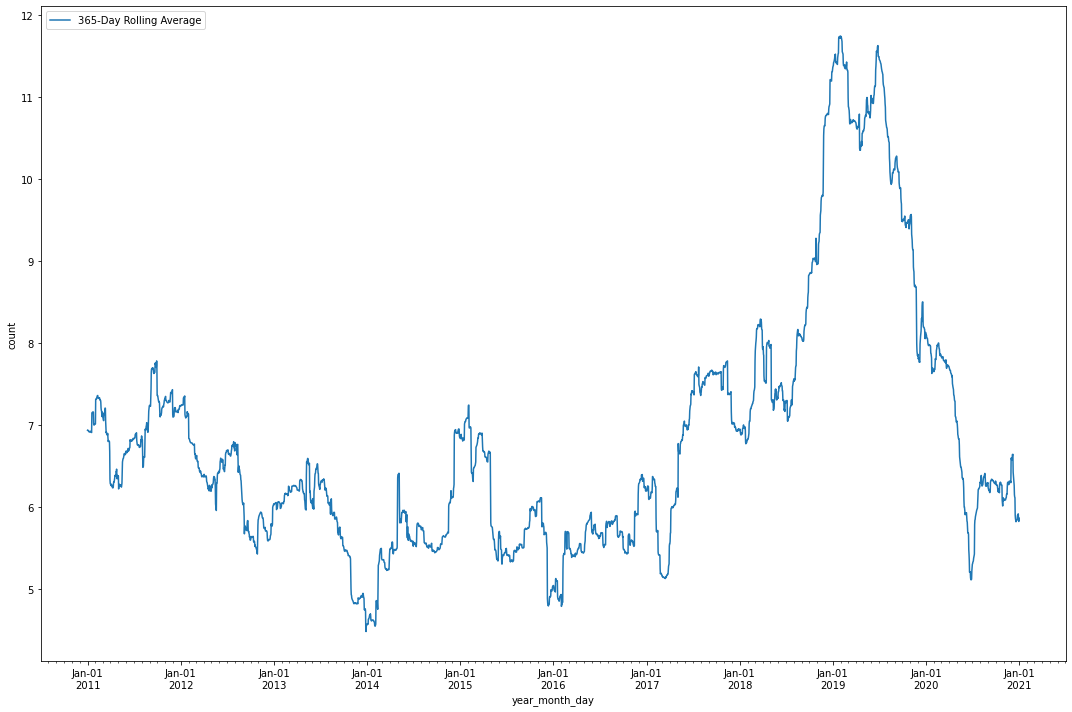

In [1120]:
fig, ax = plt.subplots(figsize=(15,10))

years = mdates.YearLocator() # every year
months = mdates.MonthLocator() # every month
years_fmt = mdates.DateFormatter('%b-%d\n%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('figures/pres-13.png')

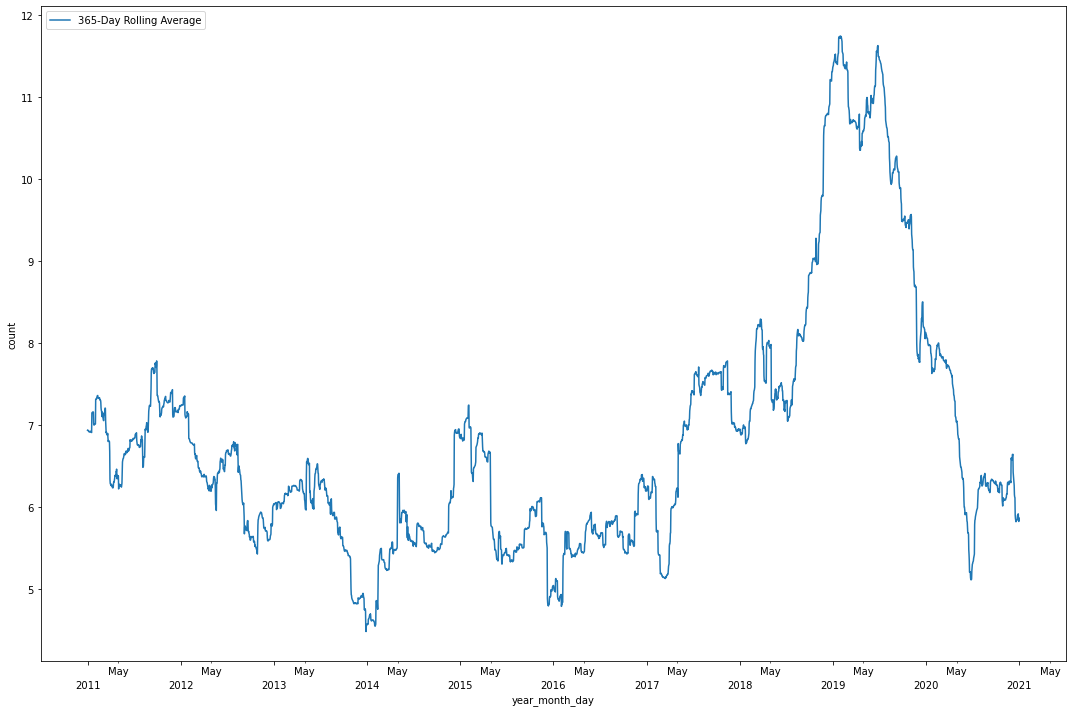

In [1121]:
fig, ax = plt.subplots(figsize=(15,10))

years = mdates.YearLocator() # every year
months = mdates.MonthLocator(5) # display on May (5)
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('figures/x_axis_label_3.png')

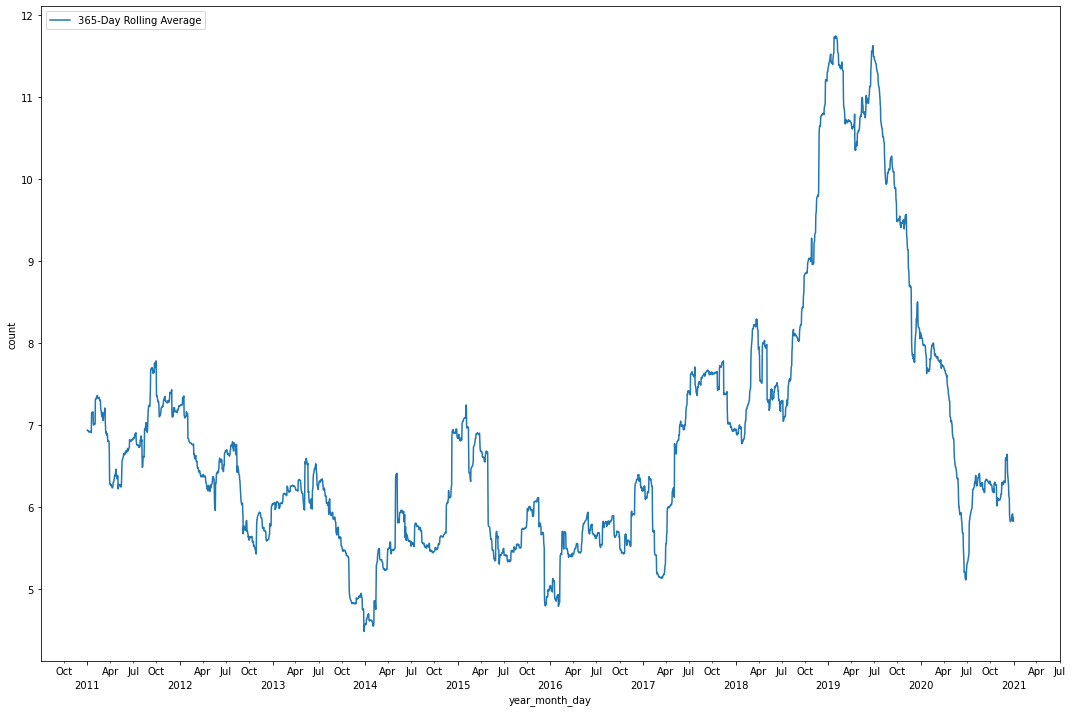

In [1122]:
fig, ax = plt.subplots(figsize=(15,10))

years = mdates.YearLocator()  # every year
months = mdates.MonthLocator(interval=3) # every 3 months
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n%Y')

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

sns.lineplot(data=flooding_311_daily.rolling(365).mean(), 
             label='365-Day Rolling Average', 
             ax=ax)

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('figures/x_axis_label_4.png')